## Config

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import seaborn as sns
pd.set_option('display.max_columns', None)
pd.option_context('mode.use_inf_as_na', True)
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## Get Actuals

In [2]:
year_df = pd.read_parquet("/Users/tomaltenborg/Documents/Master/Master thesis/Notebooks/M3 Data/M3_yearly_processed.parquet")
quart_df = pd.read_parquet("/Users/tomaltenborg/Documents/Master/Master thesis/Notebooks/M3 Data/M3_quarter_processed.parquet")
month_df = pd.read_parquet("/Users/tomaltenborg/Documents/Master/Master thesis/Notebooks/M3 Data/M3_month_processed.parquet")


In [3]:
def get_actuals (df):
    # Sort the dataframe by Series and Date
    df_sorted = df.sort_values(by=['Series', 'Date'])
    
    # Define a function that gets the last `n` entries for each group
    def last_n_entries(group):
        # `NF` is assumed to be the same for all rows in the group, so we take the first one
        n = group['NF'].iloc[0]
        return group.tail(n)
    
    # Apply the function to each group and concatenate the results
    actuals_df = df_sorted.groupby('Series').apply(last_n_entries).reset_index(drop=True)
    
    return actuals_df



In [4]:
actuals_year_df = get_actuals(year_df)
actuals_quart_df = get_actuals(quart_df)
actuals_month_df = get_actuals(month_df)

actuals_df = pd.concat([actuals_year_df, 
                        actuals_quart_df,
                        actuals_month_df],
                        ignore_index=True)



## Merge

In [5]:
forecasts_df = pd.read_parquet("/Users/tomaltenborg/Documents/Master/Master thesis/Notebooks/Analysis/complete_forecast_data.parquet")

results_df = pd.merge(forecasts_df, actuals_df[['Series', 'Date', 'Value', 'Category', 'NF']], how='left', on=['Series', 'Date'])

results_df.rename(columns={'Value': 'Actual'}, inplace=True)

# results_df.to_parquet('results.parquet', index=False, compression='snappy', engine='pyarrow')
# results_df.to_csv('results.csv')

results_df.head()

,Series,Date,TimeGPT,Chronos,Moirai,ForecastPeriod,ARARMA,Auto-ANN,AutoBox1,AutoBox2,AutoBox3,B-J auto,COMB S-H-D,DAMPEN,Flors-Pearc1,Flors-Pearc2,ForcX,ForecastPro,HOLT,NAIVE2,PP-Autocast,RBF,ROBUST-Trend,SINGLE,SMARTFCS,THETA,THETAsm,WINTER,Actual,Category,NF
0,1,1989-01-01,5121.754395,5471.703660,5075.040039,1,5553.26,5453.28,5442.92,4930.25,5168.32,5486.10,5272.43,5473.87,5473.47,4852.81,5282.58,5486.10,5406.43,4936.99,5475.80,5550.22,5204.32,4936.99,5259.0,5414.60,5163.08,5406.43,5379.75,MICRO,6
1,1,1990-01-01,4974.531738,5847.765768,5983.503906,2,6246.45,6003.49,5969.23,5479.36,5569.49,6035.21,5607.79,6010.43,6009.76,5107.47,5282.58,6035.21,5875.96,4936.99,6014.62,6152.23,5471.66,4936.99,5675.0,5934.47,5390.88,5875.96,6158.68,MICRO,6
2,1,1991-01-01,4750.660156,6195.623217,5960.694336,3,7026.18,6587.93,6495.55,5472.61,5970.65,6584.32,5943.03,6546.63,6543.37,5367.29,5282.58,6584.32,6345.48,4936.99,6553.43,6648.95,5738.99,4936.99,6091.0,6331.96,5155.17,6345.48,6876.58,MICRO,6
3,1,1992-01-01,4366.261719,6195.623217,6046.625977,4,7903.23,7206.76,7021.87,6021.72,6371.82,7133.43,6278.16,7082.48,7074.31,5632.25,5282.58,7133.43,6815.00,4936.99,7092.24,6965.22,6006.32,4936.99,6507.0,6822.35,5147.46,6815.00,7851.91,MICRO,6
4,1,1993-01-01,3914.425781,5866.568873,7204.881348,5,8889.77,7860.01,7548.18,6014.98,6772.99,7682.54,6613.17,7617.99,7602.59,5902.37,5282.58,7682.54,7284.53,4936.99,7631.05,7038.06,6273.66,4936.99,6923.0,7140.76,5152.92,7284.53,8407.84,MICRO,6


## Calculate Metrics

In [6]:
forecast_cols = [col for col in results_df.columns if col not in ['Series', 'Date', 'Naive2', 'Actual', 'ForecastPeriod', 'NF', 'Category']]

def calculate_mase_per_series(df, actual_col, forecast_cols, benchmark_col):
    results = {}

    # Calculate the MAE of the Naive2 benchmark per Series
    df['AbsErrorBenchmark'] = abs(df[actual_col] - df[benchmark_col])
    benchmark_mae = df.groupby('Series')['AbsErrorBenchmark'].mean()

    for series in df['Series'].unique():
        series_df = df[df['Series'] == series].copy()
        series_mase = {}
        for forecast_col in forecast_cols:
            # Calculate the MAE for the forecast method
            series_df['AbsErrorForecast'] = abs(series_df[actual_col] - series_df[forecast_col])
            forecast_mae = series_df['AbsErrorForecast'].mean()
            # Calculate MASE
            series_mase[forecast_col] = forecast_mae / benchmark_mae[series]
        results[series] = series_mase
    
    # Cleanup the temporary columns
    df.drop('AbsErrorBenchmark', axis=1, inplace=True)
    
    return results

# Assuming the actual column name is 'Actual'. If not, please replace 'Actual' with the actual column name.
mase_results = calculate_mase_per_series(results_df, 'Actual', forecast_cols, 'NAIVE2')

In [7]:
categories_dict = {
    'NAIVE2': 'Naive/Simple',
    'SINGLE': 'Naive/Simple',
    'HOLT': 'Naive/Simple',
    'ROBUST-Trend': 'Naive/Simple',
    'WINTER': 'Naive/Simple',
    'DAMPEN': 'Explicit Trend Models',
    'PP-Autocast': 'Explicit Trend Models',
    'THETAsm': 'Decomposition',
    'COMB S-H-D': 'Decomposition',
    'THETA': 'Decomposition',
    'B-J auto': 'ARIMA/ARARMA Models',
    'AutoBox1': 'ARIMA/ARARMA Models',
    'AutoBox2': 'ARIMA/ARARMA Models',
    'AutoBox3': 'ARIMA/ARARMA Models',
    'AAM 1': 'ARIMA/ARARMA Models',
    'AAM 2': 'ARIMA/ARARMA Models',
    'ARARMA': 'ARIMA/ARARMA Models',
    'ForecastPro': 'Expert Systems',
    'SMARTFCS': 'Expert Systems',
    'RBF': 'Expert Systems',
    'Flors-Pearc1': 'Expert Systems',
    'Flors-Pearc2': 'Expert Systems',
    'ForcX': 'Expert Systems',
    'Auto-ANN': 'Neural Networks',
    'TimeGPT': 'Transformer-based',
    'Chronos': 'Transformer-based',
    'Moirai': 'Transformer-based'
}

In [8]:
color_map = {
    'Transformer-based': '#17a2b8',  # Vivid Turquoise
    'Naive/Simple': '#c0c0c0',       # Soft Gray
    'ARIMA/ARARMA Models': '#aec6cf', # Gentle Blue
    'Explicit Trend Models': '#7393B3', # Dusty Blue
    'Decomposition': '#93e9be',        # Seafoam Green
    'Expert Systems': '#87cefa',       # Light Sky Blue
    'Neural Networks': '#e6e6fa',      # Pale Lavender
}

In [9]:
# Assuming mase_results is a dictionary where the key is the series number
# and the value is another dictionary with forecasting methods as keys and their MASE as values.

# Convert the nested dictionary into a DataFrame
mase_df = pd.DataFrame.from_dict(mase_results, orient='index')


# Calculate the average MASE for each forecasting method
median_mase = mase_df.median().sort_values()

# Convert the average MASE scores to a DataFrame for better visibility
median_mase_df = pd.DataFrame(median_mase, columns=['MedianMASE'])

median_mase_df = median_mase_df.reset_index()
median_mase_df.columns = ['Method', 'MedianMASE']

median_mase_df['Category'] = median_mase_df['Method'].map(categories_dict)

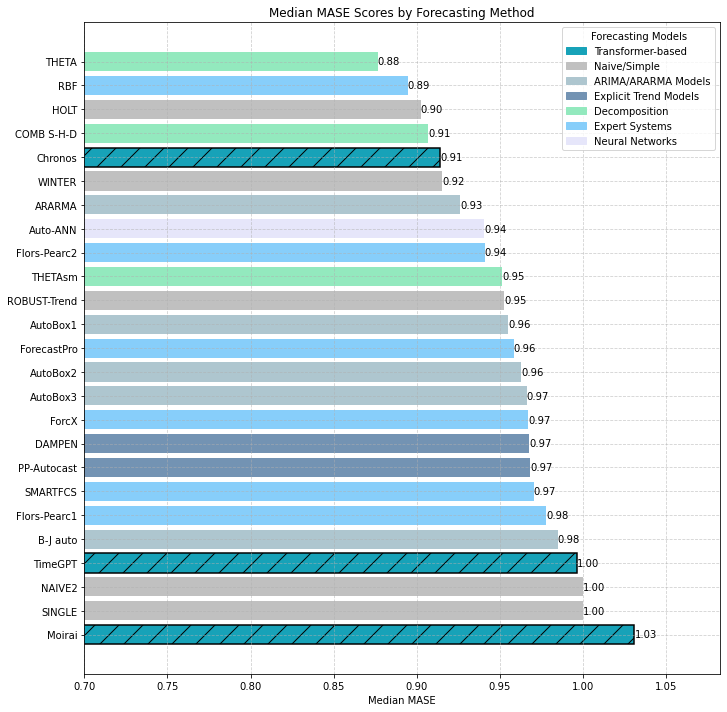

In [10]:
# Map the colors to the dataframe categories
category_colors = median_mase_df['Category'].map(color_map)

# Create a bar chart with different colors for each category
plt.figure(figsize=(12, 10))
bars = plt.barh(median_mase_df['Method'], median_mase_df['MedianMASE'], color=category_colors)

# Highlight 'Transformer-based' bars
transformer_bars = [bar for bar, method in zip(bars, median_mase_df['Method']) if median_mase_df.loc[median_mase_df['Method'] == method, 'Category'].values[0] == 'Transformer-based']
for bar in transformer_bars:
    bar.set_edgecolor('black')  # Adding a black border to the bar
    bar.set_linewidth(1.5)  # Making the border thicker
    bar.set_hatch('/')  # Adding a hatch pattern

# Add value labels to each bar
for bar in bars:
    plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2, f'{bar.get_width():.2f}', va='center', ha='left')

plt.xlabel('Median MASE')
plt.title('Median MASE Scores by Forecasting Method')
plt.gca().invert_yaxis()  # Invert y-axis to have the best method at the top
plt.legend(
    [plt.Rectangle((0,0),1,1, color=color_map[category]) for category in color_map],
    color_map.keys(),
    title="Forecasting Models",
    loc='best'  # Place the legend inside the plot in the lower right corner
)

plt.grid(True, linestyle='--', alpha=0.6)
plt.xlim(left=0.7)
plt.tight_layout(rect=[0,0,0.85,1])  # Adjust the rect to make space for the legend
plt.show()

### Training data in case different MASE calculation

In [11]:
month_temp = pd.read_parquet('/Users/tomaltenborg/Documents/Master/Master thesis/Notebooks/M3 Data/M3_month_processed.parquet')

In [12]:
def remove_n_nf(df):
    temp = []
    for series in df['Series'].unique():
        x = df[df['Series'] == series].copy()
        N = x['N'].iloc[0]
        NF = x['NF'].iloc[0]
        z = x.head(N-NF)
        temp.append(z)
    return pd.concat(temp, ignore_index=True)

In [13]:
month_train = remove_n_nf(month_temp)

## Forecast period lineplots of MASE and RMSE

In [14]:
yearly_results = results_df[results_df['NF'] == 6].copy()
quart_results = results_df[results_df['NF'] == 8].copy()
month_results = results_df[results_df['NF'] == 18].copy()

finetuned = pd.read_parquet('/Users/tomaltenborg/Documents/Master/Master thesis/Notebooks/TimeGPT/Month/M3_month_finetune_timegpt_forecasts.parquet')

In [15]:
month = pd.merge(month_results, finetuned, how='left', on=['Series', 'Date'])

### MASE by forecastperiod 

In [16]:
forecast_cols = [col for col in results_df.columns if col not in ['Series', 'Date', 'Naive2', 'Actual', 'ForecastPeriod', 'NF', 'Category']]

def calculate_mase_per_forecast_period(df, actual_col, forecast_cols, benchmark_col):
    results = {}

    # Calculate the MAE of the Naive2 benchmark per Series
    df['AbsErrorBenchmark'] = abs(df[actual_col] - df[benchmark_col])
    benchmark_mae = df.groupby('ForecastPeriod')['AbsErrorBenchmark'].mean()

    for period in df['ForecastPeriod'].unique():
        series_df = df[df['ForecastPeriod'] == period].copy()
        series_mase = {}
        for forecast_col in forecast_cols:
            # Calculate the MAE for the forecast method
            series_df['AbsErrorForecast'] = abs(series_df[actual_col] - series_df[forecast_col])
            forecast_mae = series_df['AbsErrorForecast'].mean()
            # Calculate MASE
            series_mase[forecast_col] = forecast_mae / benchmark_mae[period]
        results[period] = series_mase
    
    # Cleanup the temporary columns
    df.drop('AbsErrorBenchmark', axis=1, inplace=True)
    
    return results

mase_results_period = calculate_mase_per_forecast_period(results_df, 'Actual', forecast_cols, 'NAIVE2')
mase_results_period = pd.DataFrame.from_dict(mase_results_period, orient='index')

#### Yearly Data

In [17]:
mase_results_period_year = calculate_mase_per_forecast_period(results_df[results_df['Series'] <= 645].copy(), 'Actual', forecast_cols, 'NAIVE2')
mase_results_period_year = pd.DataFrame.from_dict(mase_results_period_year, orient='index')

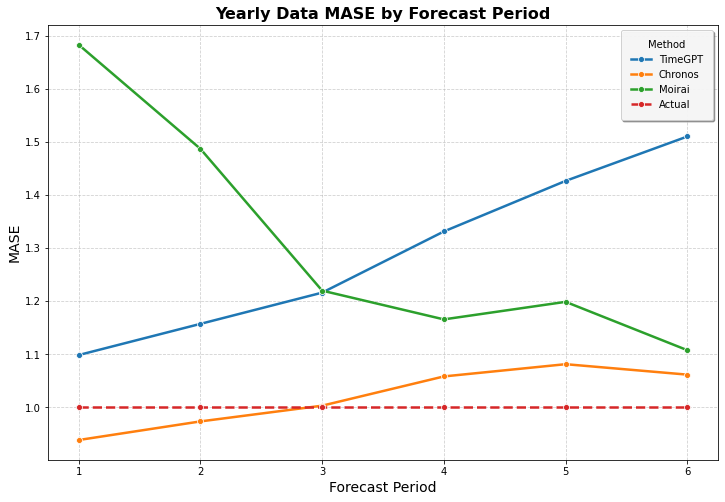

In [18]:
plt.figure(figsize=(12, 8))

# Using seaborn's lineplot for better aesthetics
sns.lineplot(x=mase_results_period_year.index, y=mase_results_period_year['TimeGPT'], marker='o', label='TimeGPT', linewidth=2.5)
sns.lineplot(x=mase_results_period_year.index, y=mase_results_period_year['Chronos'], marker='o', label='Chronos', linewidth=2.5)
sns.lineplot(x=mase_results_period_year.index, y=mase_results_period_year['Moirai'], marker='o', label='Moirai', linewidth=2.5)
sns.lineplot(x=mase_results_period_year.index, y=mase_results_period_year['NAIVE2'], marker='o', linestyle='--', label='Actual', linewidth=2.5)

# Add title and labels
plt.title('Yearly Data MASE by Forecast Period', fontsize=16, fontweight='bold')
plt.xlabel('Forecast Period', fontsize=14)
plt.ylabel('MASE', fontsize=14)
plt.legend(title='Method')

# Enhance the legend
plt.legend(title='Method', frameon=True, framealpha=0.9, shadow=True, borderpad=1)

# Add grid lines for better readability
plt.grid(True, linestyle='--', alpha=0.6)

# Show the plot
plt.show()


#### Quarterly Data

In [19]:
mase_results_period_quarter = calculate_mase_per_forecast_period(results_df[(results_df['Series'] >= 645) & (results_df['Series'] <= 1401)].copy(), 'Actual', forecast_cols, 'NAIVE2')
mase_results_period_quarter = pd.DataFrame.from_dict(mase_results_period_quarter, orient='index')

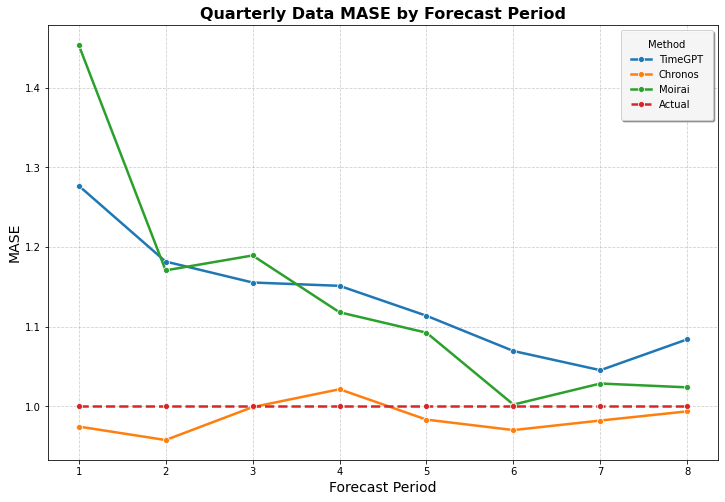

In [20]:
plt.figure(figsize=(12, 8))

# Using seaborn's lineplot for better aesthetics
sns.lineplot(x=mase_results_period_quarter.index, y=mase_results_period_quarter['TimeGPT'], marker='o', label='TimeGPT', linewidth=2.5)
sns.lineplot(x=mase_results_period_quarter.index, y=mase_results_period_quarter['Chronos'], marker='o', label='Chronos', linewidth=2.5)
sns.lineplot(x=mase_results_period_quarter.index, y=mase_results_period_quarter['Moirai'], marker='o', label='Moirai', linewidth=2.5)
sns.lineplot(x=mase_results_period_quarter.index, y=mase_results_period_quarter['NAIVE2'], marker='o', linestyle='--', label='Actual', linewidth=2.5)

# Add title and labels
plt.title('Quarterly Data MASE by Forecast Period', fontsize=16, fontweight='bold')
plt.xlabel('Forecast Period', fontsize=14)
plt.ylabel('MASE', fontsize=14)
plt.legend(title='Method')

# Enhance the legend
plt.legend(title='Method', frameon=True, framealpha=0.9, shadow=True, borderpad=1)

# Add grid lines for better readability
plt.grid(True, linestyle='--', alpha=0.6)

# Show the plot
plt.show()


#### Monthly Data

In [21]:
mase_results_period_month = calculate_mase_per_forecast_period(results_df[results_df['Series'] >= 1402].copy(), 'Actual', forecast_cols, 'NAIVE2')
mase_results_period_month = pd.DataFrame.from_dict(mase_results_period_month, orient='index')

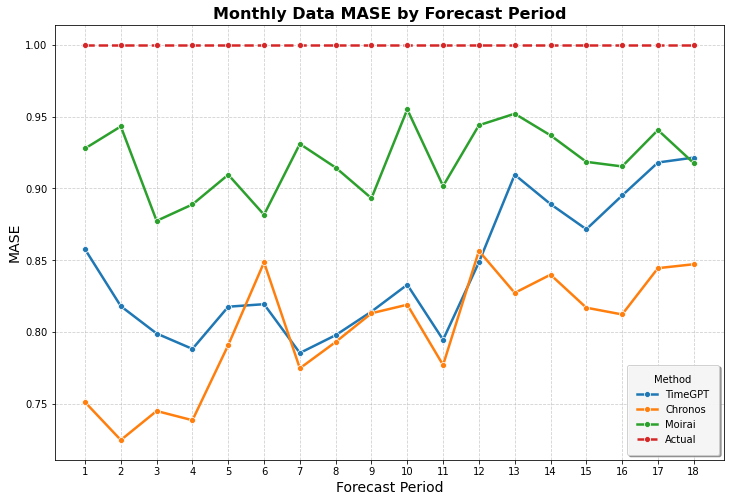

In [22]:
plt.figure(figsize=(12, 8))

# Using seaborn's lineplot for better aesthetics
sns.lineplot(x=mase_results_period_month.index, y=mase_results_period_month['TimeGPT'], marker='o', label='TimeGPT', linewidth=2.5)
sns.lineplot(x=mase_results_period_month.index, y=mase_results_period_month['Chronos'], marker='o', label='Chronos', linewidth=2.5)
sns.lineplot(x=mase_results_period_month.index, y=mase_results_period_month['Moirai'], marker='o', label='Moirai', linewidth=2.5)
sns.lineplot(x=mase_results_period_month.index, y=mase_results_period_month['NAIVE2'], marker='o', linestyle='--', label='Actual', linewidth=2.5)

# Add title and labels
plt.title('Monthly Data MASE by Forecast Period', fontsize=16, fontweight='bold')
plt.xlabel('Forecast Period', fontsize=14)
plt.ylabel('MASE', fontsize=14)
plt.legend(title='Method')
plt.xticks(range(1,18+1))
# Enhance the legend
plt.legend(title='Method', frameon=True, framealpha=0.9, shadow=True, borderpad=1)

# Add grid lines for better readability
plt.grid(True, linestyle='--', alpha=0.6)

# Show the plot
plt.show()

#### Combined

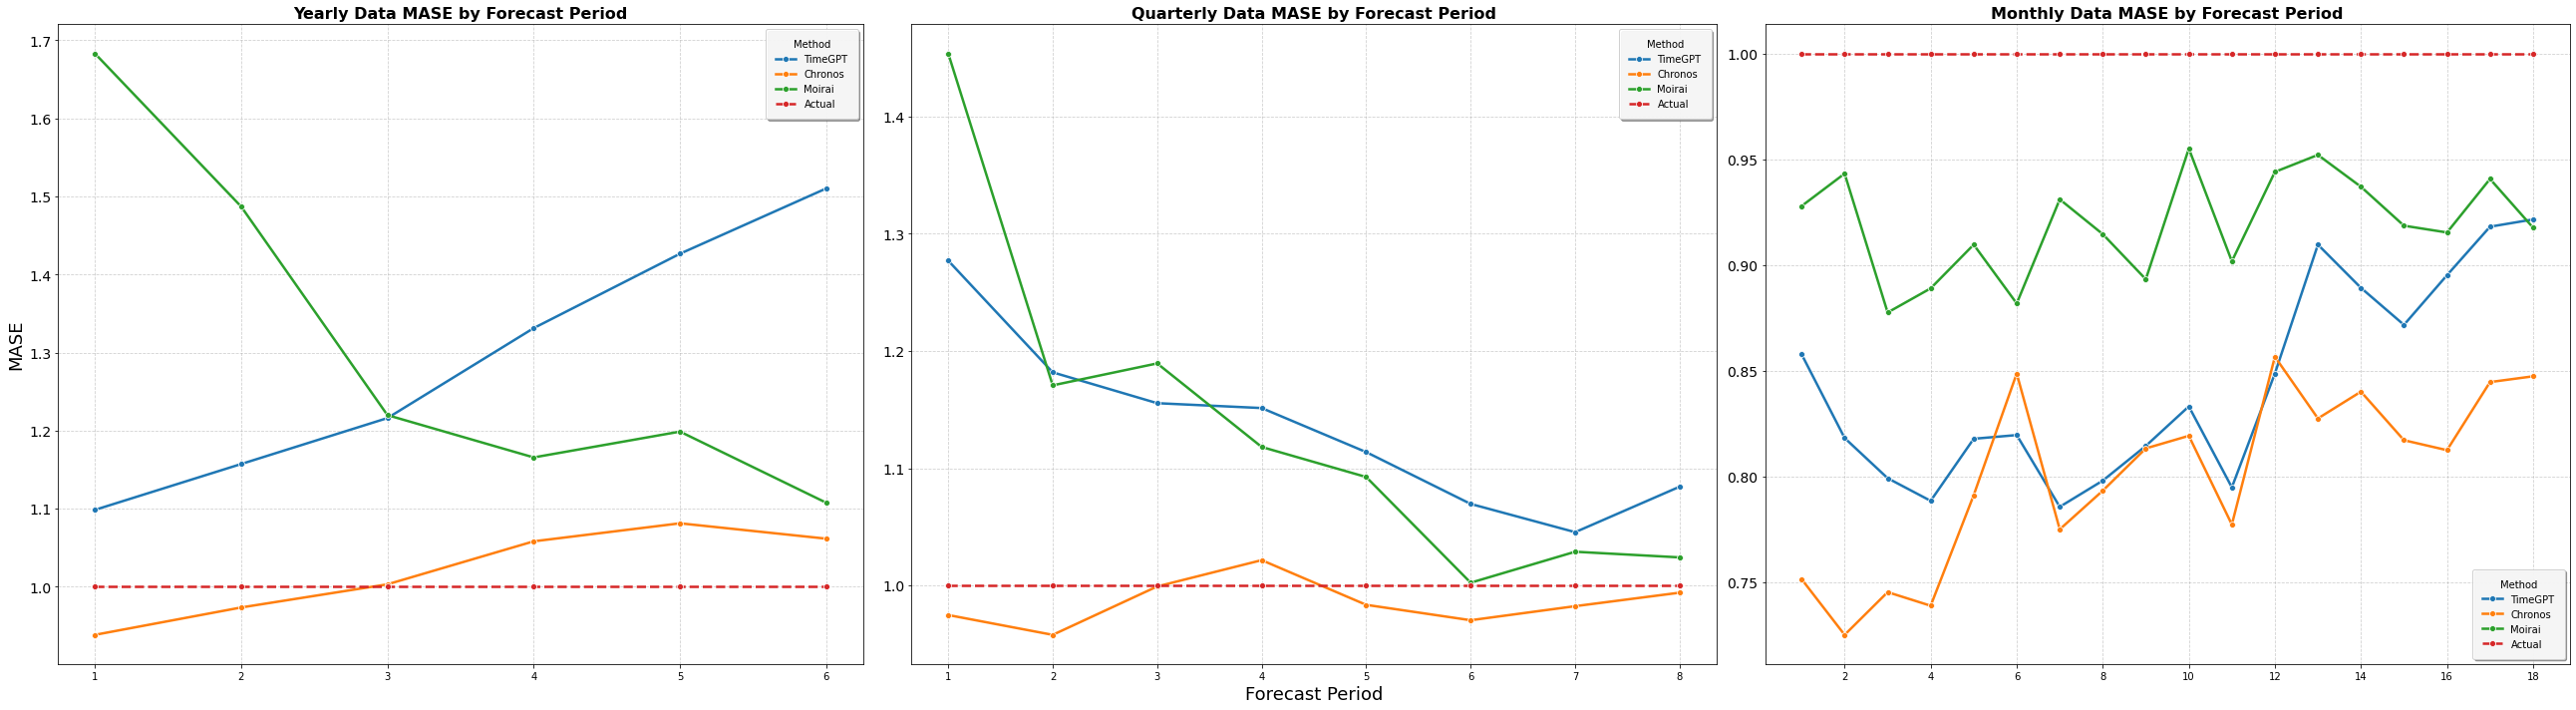

In [23]:
# Create a figure with 1 row and 3 columns of subplots
fig, axes = plt.subplots(1, 3, figsize=(36, 10))

# Yearly
sns.lineplot(ax=axes[0], x=mase_results_period_year.index, y=mase_results_period_year['TimeGPT'], marker='o', label='TimeGPT', linewidth=2.5)
sns.lineplot(ax=axes[0], x=mase_results_period_year.index, y=mase_results_period_year['Chronos'], marker='o', label='Chronos', linewidth=2.5)
sns.lineplot(ax=axes[0], x=mase_results_period_year.index, y=mase_results_period_year['Moirai'], marker='o', label='Moirai', linewidth=2.5)
sns.lineplot(ax=axes[0], x=mase_results_period_year.index, y=mase_results_period_year['NAIVE2'], marker='o', linestyle='--', label='Actual', linewidth=2.5)
# Title and labels
axes[0].set_title('Yearly Data MASE by Forecast Period', fontsize=16, fontweight='bold')
axes[0].set_xlabel('')
axes[0].set_ylabel('MASE', fontsize=18)
axes[0].legend(title='Method', frameon=True, framealpha=0.9, shadow=True, borderpad=1)
axes[0].grid(True, linestyle='--', alpha=0.6)
axes[0].set_xticks(range(1, 6+1))
axes[0].tick_params(axis='y', labelsize=14)
# Quarterly
sns.lineplot(ax=axes[1], x=mase_results_period_quarter.index, y=mase_results_period_quarter['TimeGPT'], marker='o', label='TimeGPT', linewidth=2.5)
sns.lineplot(ax=axes[1], x=mase_results_period_quarter.index, y=mase_results_period_quarter['Chronos'], marker='o', label='Chronos', linewidth=2.5)
sns.lineplot(ax=axes[1], x=mase_results_period_quarter.index, y=mase_results_period_quarter['Moirai'], marker='o', label='Moirai', linewidth=2.5)
sns.lineplot(ax=axes[1], x=mase_results_period_quarter.index, y=mase_results_period_quarter['NAIVE2'], marker='o', linestyle='--', label='Actual', linewidth=2.5)
# Title and labels
axes[1].set_title('Quarterly Data MASE by Forecast Period', fontsize=16, fontweight='bold')
axes[1].set_xlabel('Forecast Period', fontsize=18)
axes[1].set_ylabel('')
axes[1].legend(title='Method', frameon=True, framealpha=0.9, shadow=True, borderpad=1)
axes[1].grid(True, linestyle='--', alpha=0.6)
axes[1].set_xticks(range(1, 8+1))
axes[1].tick_params(axis='y', labelsize=14)

# Monthly
sns.lineplot(ax=axes[2], x=mase_results_period_month.index, y=mase_results_period_month['TimeGPT'], marker='o', label='TimeGPT', linewidth=2.5)
sns.lineplot(ax=axes[2], x=mase_results_period_month.index, y=mase_results_period_month['Chronos'], marker='o', label='Chronos', linewidth=2.5)
sns.lineplot(ax=axes[2], x=mase_results_period_month.index, y=mase_results_period_month['Moirai'], marker='o', label='Moirai', linewidth=2.5)
sns.lineplot(ax=axes[2], x=mase_results_period_month.index, y=mase_results_period_month['NAIVE2'], marker='o', linestyle='--', label='Actual', linewidth=2.5)
# Title and labels
axes[2].set_title('Monthly Data MASE by Forecast Period', fontsize=16, fontweight='bold')
axes[2].set_xlabel('')
axes[2].set_ylabel('')
axes[2].legend(title='Method', frameon=True, framealpha=0.9, shadow=True, borderpad=1)
axes[2].grid(True, linestyle='--', alpha=0.6)
axes[2].set_xticks(range(2, 18+1, 2))
axes[2].tick_params(axis='y', labelsize=14)

# Adjust layout to prevent overlapping
plt.tight_layout()

plt.show()

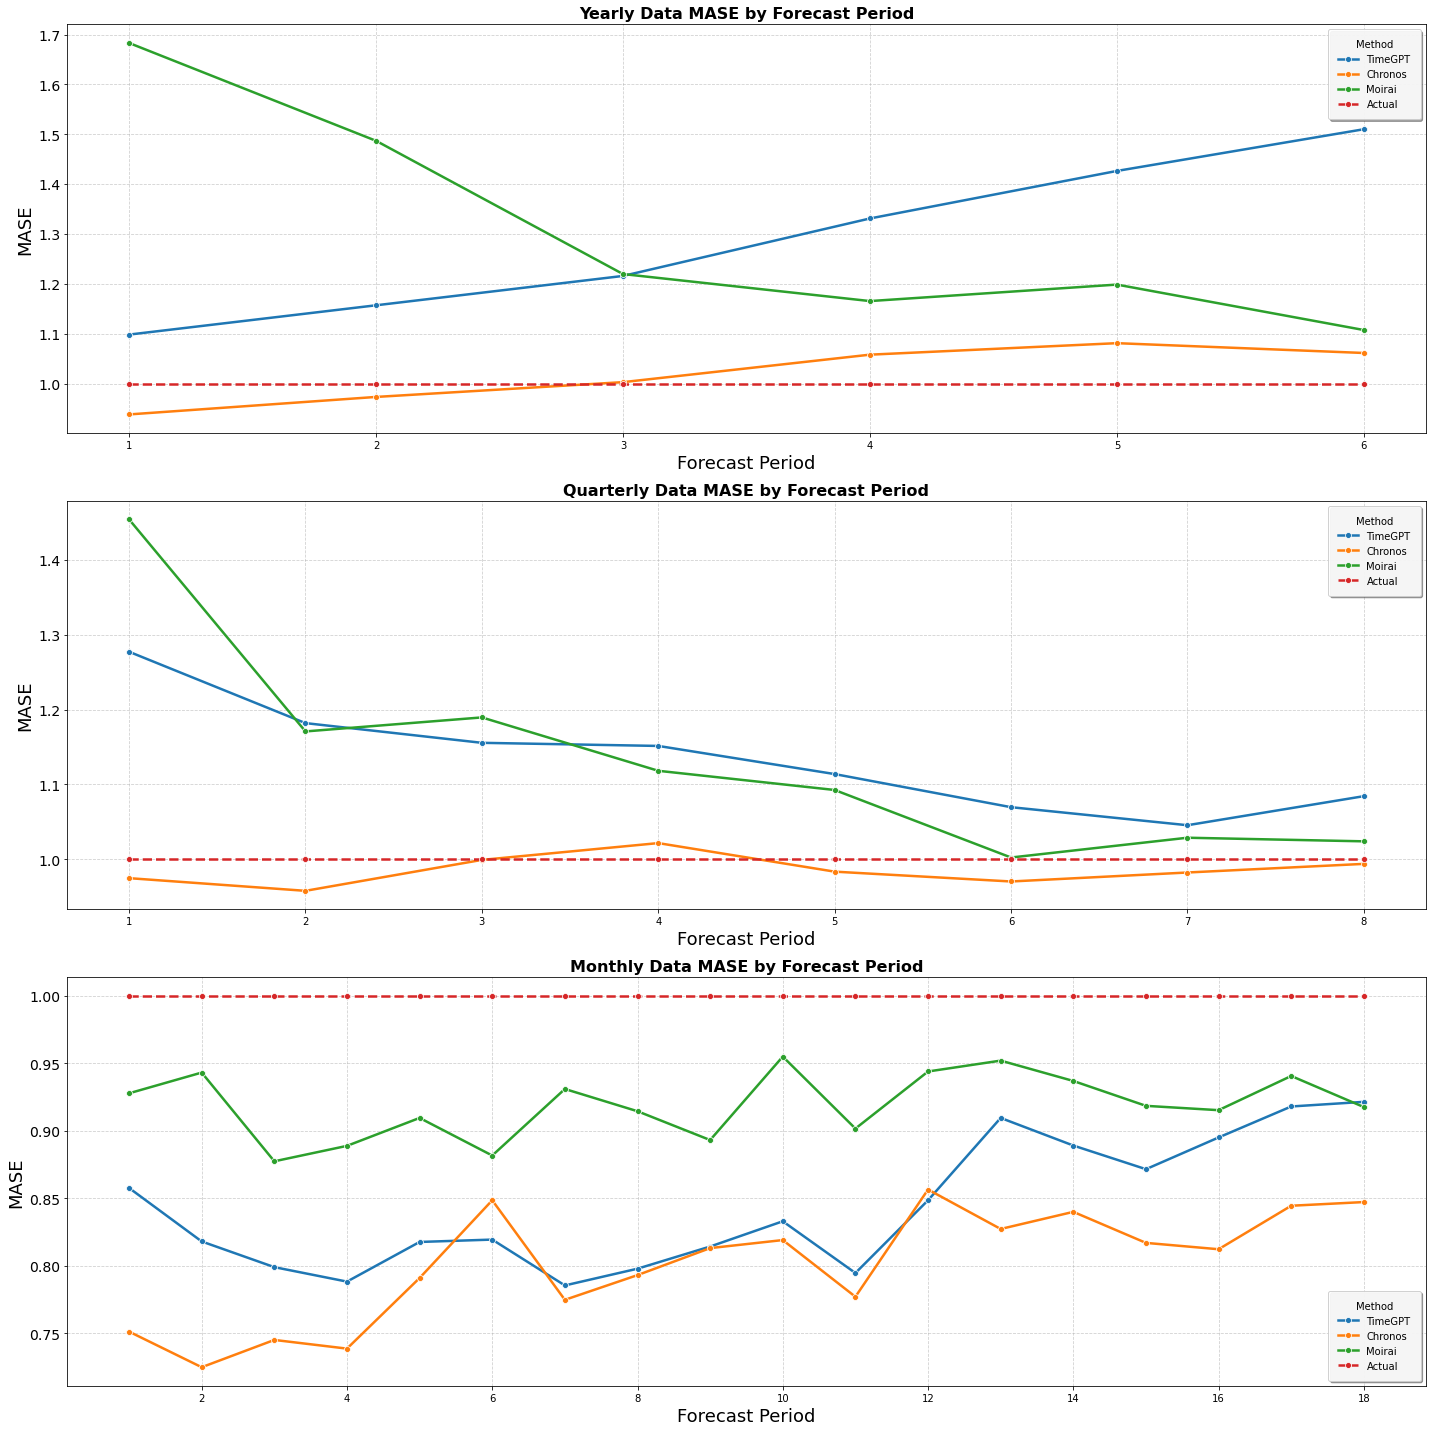

In [24]:
# Create a figure with 1 row and 3 columns of subplots
fig, axes = plt.subplots(3, 1, figsize=(20, 20))

# Yearly
sns.lineplot(ax=axes[0], x=mase_results_period_year.index, y=mase_results_period_year['TimeGPT'], marker='o', label='TimeGPT', linewidth=2.5)
sns.lineplot(ax=axes[0], x=mase_results_period_year.index, y=mase_results_period_year['Chronos'], marker='o', label='Chronos', linewidth=2.5)
sns.lineplot(ax=axes[0], x=mase_results_period_year.index, y=mase_results_period_year['Moirai'], marker='o', label='Moirai', linewidth=2.5)
sns.lineplot(ax=axes[0], x=mase_results_period_year.index, y=mase_results_period_year['NAIVE2'], marker='o', linestyle='--', label='Actual', linewidth=2.5)
# Title and labels
axes[0].set_title('Yearly Data MASE by Forecast Period', fontsize=16, fontweight='bold')
axes[0].set_xlabel('Forecast Period', fontsize=18)
axes[0].set_ylabel('MASE', fontsize=18)
axes[0].legend(title='Method', frameon=True, framealpha=0.9, shadow=True, borderpad=1)
axes[0].grid(True, linestyle='--', alpha=0.6)
axes[0].set_xticks(range(1, 6+1))
axes[0].tick_params(axis='y', labelsize=14)
# Quarterly
sns.lineplot(ax=axes[1], x=mase_results_period_quarter.index, y=mase_results_period_quarter['TimeGPT'], marker='o', label='TimeGPT', linewidth=2.5)
sns.lineplot(ax=axes[1], x=mase_results_period_quarter.index, y=mase_results_period_quarter['Chronos'], marker='o', label='Chronos', linewidth=2.5)
sns.lineplot(ax=axes[1], x=mase_results_period_quarter.index, y=mase_results_period_quarter['Moirai'], marker='o', label='Moirai', linewidth=2.5)
sns.lineplot(ax=axes[1], x=mase_results_period_quarter.index, y=mase_results_period_quarter['NAIVE2'], marker='o', linestyle='--', label='Actual', linewidth=2.5)
# Title and labels
axes[1].set_title('Quarterly Data MASE by Forecast Period', fontsize=16, fontweight='bold')
axes[1].set_xlabel('Forecast Period', fontsize=18)
axes[1].set_ylabel('MASE', fontsize=18)
axes[1].legend(title='Method', frameon=True, framealpha=0.9, shadow=True, borderpad=1)
axes[1].grid(True, linestyle='--', alpha=0.6)
axes[1].set_xticks(range(1, 8+1))
axes[1].tick_params(axis='y', labelsize=14)

# Monthly
sns.lineplot(ax=axes[2], x=mase_results_period_month.index, y=mase_results_period_month['TimeGPT'], marker='o', label='TimeGPT', linewidth=2.5)
sns.lineplot(ax=axes[2], x=mase_results_period_month.index, y=mase_results_period_month['Chronos'], marker='o', label='Chronos', linewidth=2.5)
sns.lineplot(ax=axes[2], x=mase_results_period_month.index, y=mase_results_period_month['Moirai'], marker='o', label='Moirai', linewidth=2.5)
sns.lineplot(ax=axes[2], x=mase_results_period_month.index, y=mase_results_period_month['NAIVE2'], marker='o', linestyle='--', label='Actual', linewidth=2.5)
# Title and labels
axes[2].set_title('Monthly Data MASE by Forecast Period', fontsize=16, fontweight='bold')
axes[2].set_xlabel('Forecast Period', fontsize=18)
axes[2].set_ylabel('MASE', fontsize=18)
axes[2].legend(title='Method', frameon=True, framealpha=0.9, shadow=True, borderpad=1)
axes[2].grid(True, linestyle='--', alpha=0.6)
axes[2].set_xticks(range(2, 18+1, 2))
axes[2].tick_params(axis='y', labelsize=14)

# Adjust layout to prevent overlapping
plt.tight_layout()

plt.show()

### RMSE by forecast period

In [25]:
def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

In [26]:
def calculate_log_transformed_rmse_per_forecast_period(df, actual_col, forecast_cols, benchmark_col):
    results = {}
    
    # Ensure all actual and forecast values are positive
    # You might adjust this depending on your data specifics
    small_constant = 1e-6  # A small constant to avoid taking log of zero

    # Apply log transformation, adding a small constant to avoid log(0)
    df['Log_Actual'] = np.log(df[actual_col] + small_constant)
    df['Log_Benchmark'] = np.log(df[benchmark_col] + small_constant)

    # Calculate the Squared Error of the log-transformed benchmark (Naive2)
    df['SquaredErrorBenchmark'] = (df['Log_Actual'] - df['Log_Benchmark']) ** 2
    benchmark_rmse = np.sqrt(df.groupby('ForecastPeriod')['SquaredErrorBenchmark'].mean())

    for period in df['ForecastPeriod'].unique():
        series_df = df[df['ForecastPeriod'] == period].copy()
        series_rmse = {}
        for forecast_col in forecast_cols:
            # Apply log transformation to forecast columns
            series_df[f'{forecast_col}'] = np.log(series_df[forecast_col] + small_constant)

            # Calculate the Squared Error for the log-transformed forecast method
            series_df['SquaredErrorForecast'] = (series_df['Log_Actual'] - series_df[f'{forecast_col}']) ** 2
            forecast_rmse = np.sqrt(series_df['SquaredErrorForecast'].mean())
            
            # Store RMSE directly, no scaling like MASE
            series_rmse[forecast_col] = forecast_rmse
        results[period] = series_rmse

    # Cleanup the temporary columns
    df.drop(['Log_Actual', 'Log_Benchmark', 'SquaredErrorBenchmark'], axis=1, inplace=True)
    
    return results


#### Yearly

In [27]:
rmse_results_period_year = calculate_log_transformed_rmse_per_forecast_period(results_df[results_df['Series'] <= 645].copy(), 'Actual', forecast_cols, 'NAIVE2')
rmse_results_period_year = pd.DataFrame.from_dict(rmse_results_period_year, orient='index')

/Users/tomaltenborg/anaconda3/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/tomaltenborg/anaconda3/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/tomaltenborg/anaconda3/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/tomaltenborg/anaconda3/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/tomaltenborg/anaconda3/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/tomaltenborg/anaconda3/lib/python3.11/

In [28]:
rmse_results_period_year

,TimeGPT,Chronos,Moirai,ARARMA,Auto-ANN,AutoBox1,AutoBox2,AutoBox3,B-J auto,COMB S-H-D,DAMPEN,Flors-Pearc1,Flors-Pearc2,ForcX,ForecastPro,HOLT,NAIVE2,PP-Autocast,RBF,ROBUST-Trend,SINGLE,SMARTFCS,THETA,THETAsm,WINTER
1,0.147704,0.144782,0.187053,0.182445,0.291224,0.193771,0.145939,1.162366,0.156453,0.137286,0.141787,0.149740,0.174815,0.154689,0.153576,0.148404,0.148766,0.141367,0.147384,0.146922,0.139851,0.166420,0.140161,0.155949,0.148404
2,0.260602,0.244977,0.337880,0.322604,0.350802,0.308821,0.244132,1.189262,0.256636,0.253080,0.258385,0.259057,0.265553,0.251219,0.246196,0.864717,0.247528,0.256117,0.249063,0.266808,0.250450,0.262571,0.254686,0.256141,0.864717
3,0.342560,0.307199,0.329878,0.378256,0.313911,0.401111,0.300596,1.221424,0.320559,0.319867,0.921406,0.324330,0.314886,0.302105,0.320263,1.749437,0.308145,0.415774,0.310163,0.325848,0.305198,0.323950,0.317758,0.314427,1.749437
4,0.399537,0.342419,0.352302,0.376581,0.344886,0.470054,0.869366,1.714171,0.350109,0.344389,1.282277,0.356952,0.327603,0.321614,0.883361,2.140360,0.326230,0.936344,0.315174,0.343174,0.325544,0.342616,0.344238,0.363658,2.140360
5,0.464151,0.372599,0.381520,0.416811,0.415614,0.541041,0.880262,1.726946,0.363968,0.372138,1.293232,0.385366,0.356984,0.343371,1.249931,2.465647,0.349984,0.949190,0.346415,0.370032,0.348812,0.399308,0.369415,0.919443,2.465647
6,0.543679,0.405779,0.399382,0.448596,0.403949,0.590590,0.889145,2.113924,0.390341,0.389287,1.300193,0.417011,0.384437,0.374704,1.258433,2.729852,0.377317,0.956458,0.367700,0.391335,0.379978,0.423904,0.402784,0.935171,2.729852


### Quarterly

In [29]:
rmse_results_period_quarter = calculate_log_transformed_rmse_per_forecast_period(results_df[(results_df['Series'] > 645) & (results_df['Series'] <= 1401)].copy(), 'Actual', forecast_cols, 'NAIVE2')
rmse_results_period_quarter = pd.DataFrame.from_dict(rmse_results_period_quarter, orient='index')

/Users/tomaltenborg/anaconda3/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/tomaltenborg/anaconda3/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/tomaltenborg/anaconda3/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/tomaltenborg/anaconda3/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/tomaltenborg/anaconda3/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/tomaltenborg/anaconda3/lib/python3.11/

### Monthly

In [30]:
rmse_results_period_month = calculate_log_transformed_rmse_per_forecast_period(results_df[results_df['Series'] > 1401].copy(), 'Actual', forecast_cols, 'NAIVE2')
rmse_results_period_month = pd.DataFrame.from_dict(rmse_results_period_month, orient='index')

/Users/tomaltenborg/anaconda3/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/tomaltenborg/anaconda3/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/tomaltenborg/anaconda3/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/tomaltenborg/anaconda3/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/tomaltenborg/anaconda3/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/tomaltenborg/anaconda3/lib/python3.11/

### Combined

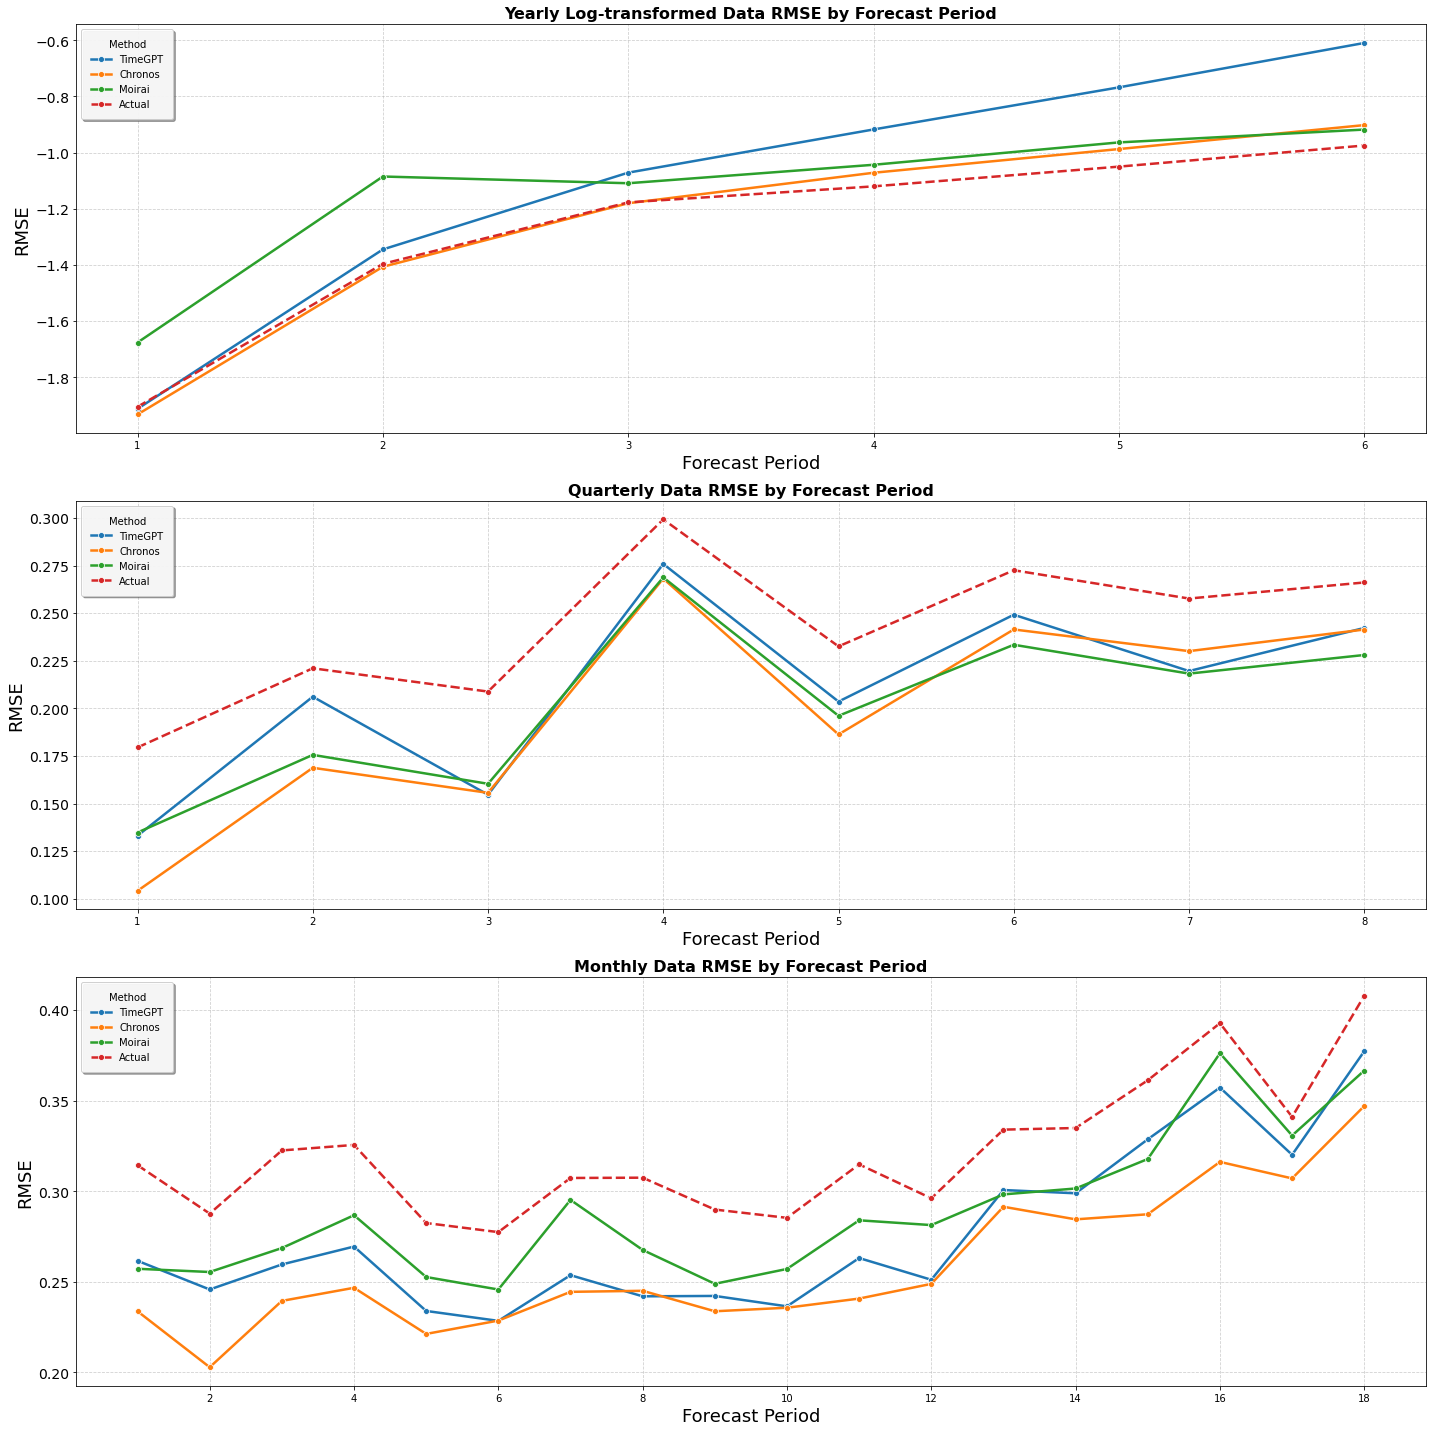

In [31]:
# Create a figure with 1 row and 3 columns of subplots
fig, axes = plt.subplots(3, 1, figsize=(20, 20))

# Yearly
sns.lineplot(ax=axes[0], x=rmse_results_period_year.index, y=np.log(rmse_results_period_year)['TimeGPT'], marker='o', label='TimeGPT', linewidth=2.5)
sns.lineplot(ax=axes[0], x=rmse_results_period_year.index, y=np.log(rmse_results_period_year)['Chronos'], marker='o', label='Chronos', linewidth=2.5)
sns.lineplot(ax=axes[0], x=rmse_results_period_year.index, y=np.log(rmse_results_period_year)['Moirai'], marker='o', label='Moirai', linewidth=2.5)
sns.lineplot(ax=axes[0], x=rmse_results_period_year.index, y=np.log(rmse_results_period_year)['NAIVE2'], marker='o', linestyle='--', label='Actual', linewidth=2.5)
# Title and labels
axes[0].set_title('Yearly Log-transformed Data RMSE by Forecast Period', fontsize=16, fontweight='bold')
axes[0].set_xlabel('Forecast Period', fontsize=18)
axes[0].set_ylabel('RMSE', fontsize=18)
axes[0].legend(title='Method', frameon=True, framealpha=0.9, shadow=True, borderpad=1)
axes[0].grid(True, linestyle='--', alpha=0.6)
axes[0].set_xticks(range(1, 6+1))
axes[0].tick_params(axis='y', labelsize=14)
# Quarterly
sns.lineplot(ax=axes[1], x=rmse_results_period_quarter.index, y=rmse_results_period_quarter['TimeGPT'], marker='o', label='TimeGPT', linewidth=2.5)
sns.lineplot(ax=axes[1], x=rmse_results_period_quarter.index, y=rmse_results_period_quarter['Chronos'], marker='o', label='Chronos', linewidth=2.5)
sns.lineplot(ax=axes[1], x=rmse_results_period_quarter.index, y=rmse_results_period_quarter['Moirai'], marker='o', label='Moirai', linewidth=2.5)
sns.lineplot(ax=axes[1], x=rmse_results_period_quarter.index, y=rmse_results_period_quarter['NAIVE2'], marker='o', linestyle='--', label='Actual', linewidth=2.5)
# Title and labels
axes[1].set_title('Quarterly Data RMSE by Forecast Period', fontsize=16, fontweight='bold')
axes[1].set_xlabel('Forecast Period', fontsize=18)
axes[1].set_ylabel('RMSE', fontsize=18)
axes[1].legend(title='Method', frameon=True, framealpha=0.9, shadow=True, borderpad=1)
axes[1].grid(True, linestyle='--', alpha=0.6)
axes[1].set_xticks(range(1, 8+1))
axes[1].tick_params(axis='y', labelsize=14)

# Monthly
sns.lineplot(ax=axes[2], x=rmse_results_period_month.index, y=rmse_results_period_month['TimeGPT'], marker='o', label='TimeGPT', linewidth=2.5)
sns.lineplot(ax=axes[2], x=rmse_results_period_month.index, y=rmse_results_period_month['Chronos'], marker='o', label='Chronos', linewidth=2.5)
sns.lineplot(ax=axes[2], x=rmse_results_period_month.index, y=rmse_results_period_month['Moirai'], marker='o', label='Moirai', linewidth=2.5)
sns.lineplot(ax=axes[2], x=rmse_results_period_month.index, y=rmse_results_period_month['NAIVE2'], marker='o', linestyle='--', label='Actual', linewidth=2.5)
# Title and labels
axes[2].set_title('Monthly Data RMSE by Forecast Period', fontsize=16, fontweight='bold')
axes[2].set_xlabel('Forecast Period', fontsize=18)
axes[2].set_ylabel('RMSE', fontsize=18)
axes[2].legend(title='Method', frameon=True, framealpha=0.9, shadow=True, borderpad=1)
axes[2].grid(True, linestyle='--', alpha=0.6)
axes[2].set_xticks(range(2, 18+1, 2))
axes[2].tick_params(axis='y', labelsize=14)

# Adjust layout to prevent overlapping
plt.tight_layout()

plt.show()

### Combine MASE and RMSE Into 3x2 plot

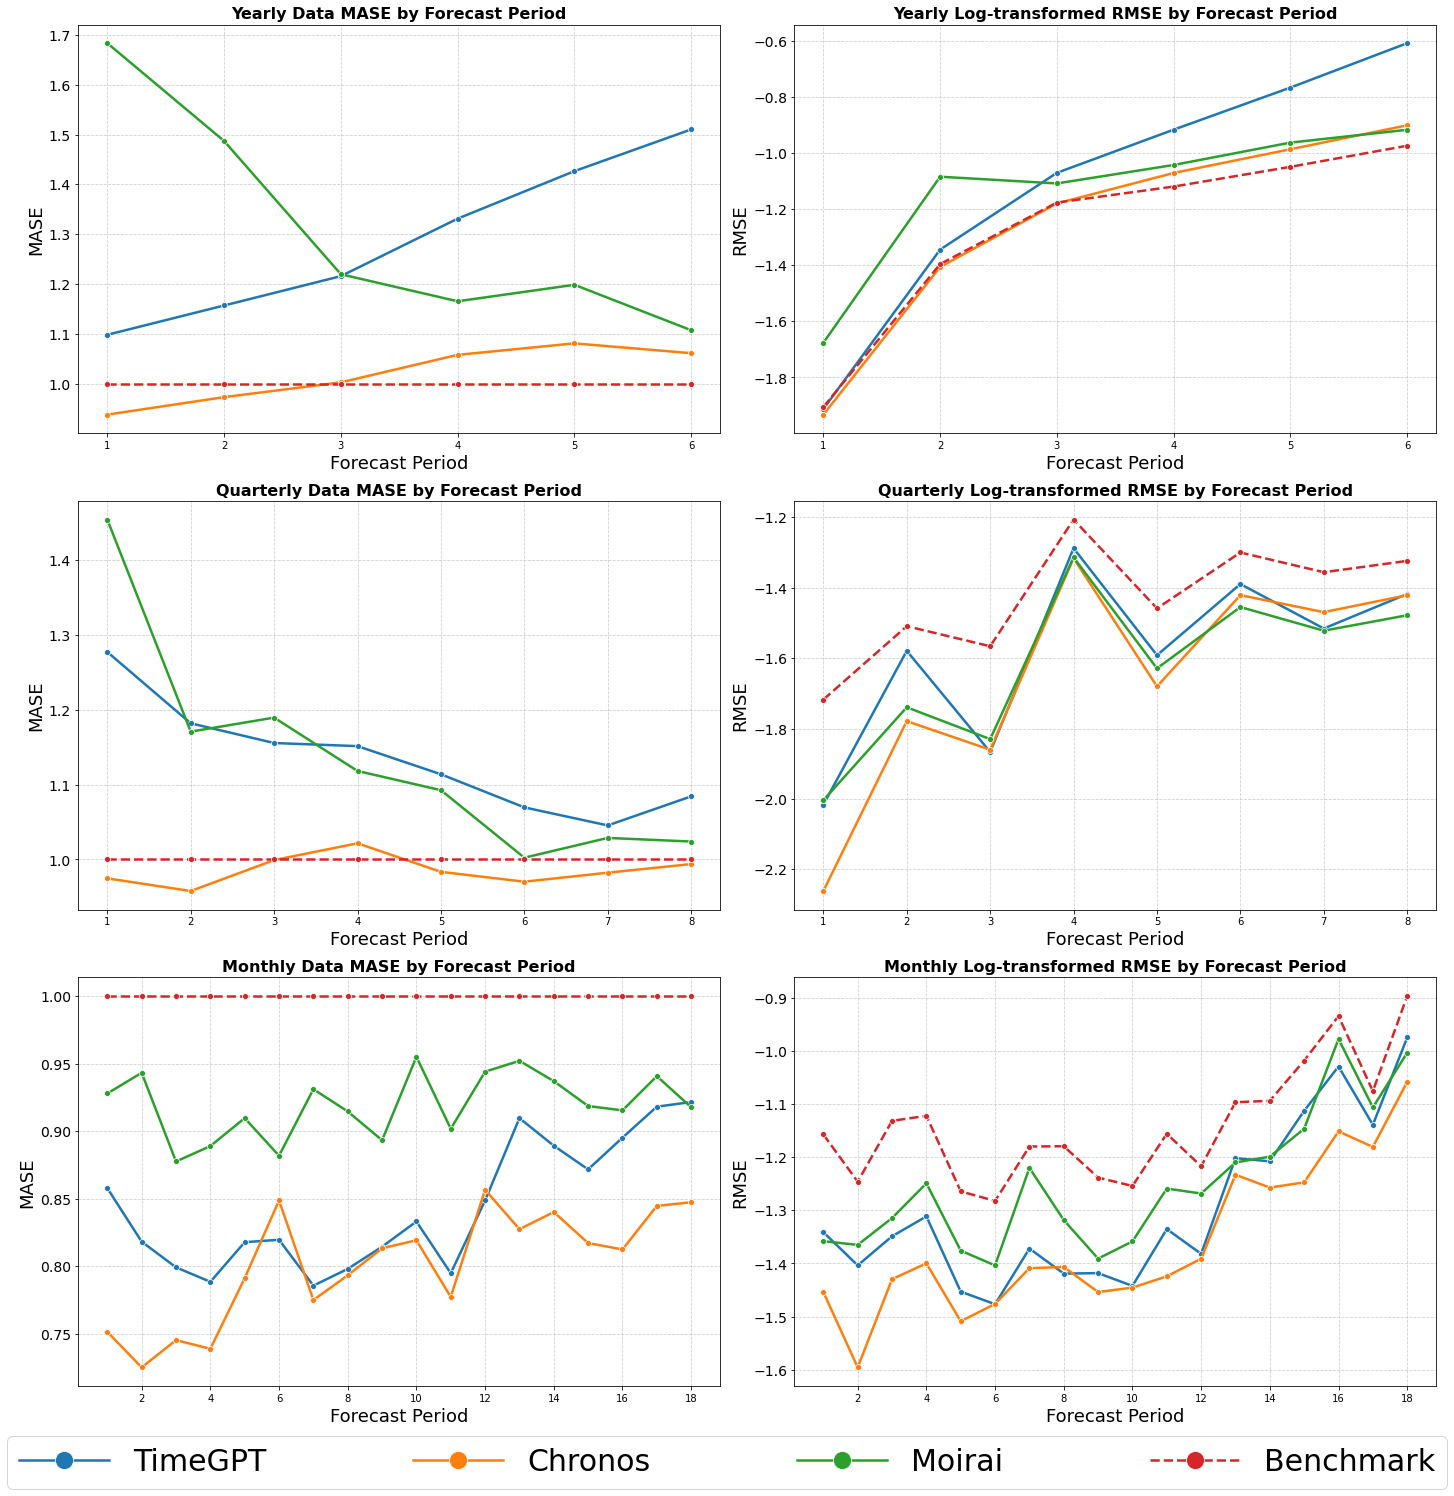

In [32]:
# Create a figure with 1 row and 3 columns of subplots
fig, axes = plt.subplots(3, 2, figsize=(20, 20))

### MASE ###

# Yearly
sns.lineplot(ax=axes[0, 0], x=mase_results_period_year.index, y=mase_results_period_year['TimeGPT'], marker='o', label='TimeGPT', linewidth=2.5)
sns.lineplot(ax=axes[0, 0], x=mase_results_period_year.index, y=mase_results_period_year['Chronos'], marker='o', label='Chronos', linewidth=2.5)
sns.lineplot(ax=axes[0, 0], x=mase_results_period_year.index, y=mase_results_period_year['Moirai'], marker='o', label='Moirai', linewidth=2.5)
sns.lineplot(ax=axes[0, 0], x=mase_results_period_year.index, y=mase_results_period_year['NAIVE2'], marker='o', linestyle='--', label='Benchmark', linewidth=2.5)
# Title and labels
axes[0, 0].set_title('Yearly Data MASE by Forecast Period', fontsize=16, fontweight='bold')
axes[0, 0].set_xlabel('Forecast Period', fontsize=18)
axes[0, 0].set_ylabel('MASE', fontsize=18)
axes[0, 0].grid(True, linestyle='--', alpha=0.6)
axes[0, 0].set_xticks(range(1, 6+1))
axes[0, 0].tick_params(axis='y', labelsize=14)

# Quarterly
sns.lineplot(ax=axes[1, 0], x=mase_results_period_quarter.index, y=mase_results_period_quarter['TimeGPT'], marker='o', label='TimeGPT', linewidth=2.5)
sns.lineplot(ax=axes[1, 0], x=mase_results_period_quarter.index, y=mase_results_period_quarter['Chronos'], marker='o', label='Chronos', linewidth=2.5)
sns.lineplot(ax=axes[1, 0], x=mase_results_period_quarter.index, y=mase_results_period_quarter['Moirai'], marker='o', label='Moirai', linewidth=2.5)
sns.lineplot(ax=axes[1, 0], x=mase_results_period_quarter.index, y=mase_results_period_quarter['NAIVE2'], marker='o', linestyle='--', label='Benchmark', linewidth=2.5)
# Title and labels
axes[1, 0].set_title('Quarterly Data MASE by Forecast Period', fontsize=16, fontweight='bold')
axes[1, 0].set_xlabel('Forecast Period', fontsize=18)
axes[1, 0].set_ylabel('MASE', fontsize=18)
axes[1, 0].grid(True, linestyle='--', alpha=0.6)
axes[1, 0].set_xticks(range(1, 8+1))
axes[1, 0].tick_params(axis='y', labelsize=14)

# Monthly
sns.lineplot(ax=axes[2, 0], x=mase_results_period_month.index, y=mase_results_period_month['TimeGPT'], marker='o', label='TimeGPT', linewidth=2.5)
sns.lineplot(ax=axes[2, 0], x=mase_results_period_month.index, y=mase_results_period_month['Chronos'], marker='o', label='Chronos', linewidth=2.5)
sns.lineplot(ax=axes[2, 0], x=mase_results_period_month.index, y=mase_results_period_month['Moirai'], marker='o', label='Moirai', linewidth=2.5)
sns.lineplot(ax=axes[2, 0], x=mase_results_period_month.index, y=mase_results_period_month['NAIVE2'], marker='o', linestyle='--', label='Benchmark', linewidth=2.5)
# Title and labels
axes[2, 0].set_title('Monthly Data MASE by Forecast Period', fontsize=16, fontweight='bold')
axes[2, 0].set_xlabel('Forecast Period', fontsize=18)
axes[2, 0].set_ylabel('MASE', fontsize=18)
axes[2, 0].grid(True, linestyle='--', alpha=0.6)
axes[2, 0].set_xticks(range(2, 18+1, 2))
axes[2, 0].tick_params(axis='y', labelsize=14)


### RMSE ###

# Yearly
sns.lineplot(ax=axes[0, 1], x=rmse_results_period_year.index, y=np.log(rmse_results_period_year['TimeGPT']), marker='o', label='TimeGPT', linewidth=2.5)
sns.lineplot(ax=axes[0, 1], x=rmse_results_period_year.index, y=np.log(rmse_results_period_year['Chronos']), marker='o', label='Chronos', linewidth=2.5)
sns.lineplot(ax=axes[0, 1], x=rmse_results_period_year.index, y=np.log(rmse_results_period_year['Moirai']), marker='o', label='Moirai', linewidth=2.5)
sns.lineplot(ax=axes[0, 1], x=rmse_results_period_year.index, y=np.log(rmse_results_period_year['NAIVE2']), marker='o', linestyle='--', label='Benchmark', linewidth=2.5)
# Title and labels
axes[0, 1].set_title('Yearly Log-transformed RMSE by Forecast Period', fontsize=16, fontweight='bold')
axes[0, 1].set_xlabel('Forecast Period', fontsize=18)
axes[0, 1].set_ylabel('RMSE', fontsize=18)
axes[0, 1].grid(True, linestyle='--', alpha=0.6)
axes[0, 1].set_xticks(range(1, 6+1))
axes[0, 1].tick_params(axis='y', labelsize=14)

# Quarterly
sns.lineplot(ax=axes[1, 1], x=rmse_results_period_quarter.index, y=np.log(rmse_results_period_quarter['TimeGPT']), marker='o', label='TimeGPT', linewidth=2.5)
sns.lineplot(ax=axes[1, 1], x=rmse_results_period_quarter.index, y=np.log(rmse_results_period_quarter['Chronos']), marker='o', label='Chronos', linewidth=2.5)
sns.lineplot(ax=axes[1, 1], x=rmse_results_period_quarter.index, y=np.log(rmse_results_period_quarter['Moirai']), marker='o', label='Moirai', linewidth=2.5)
sns.lineplot(ax=axes[1, 1], x=rmse_results_period_quarter.index, y=np.log(rmse_results_period_quarter['NAIVE2']), marker='o', linestyle='--', label='Benchmark', linewidth=2.5)
# Title and labels
axes[1, 1].set_title('Quarterly Log-transformed RMSE by Forecast Period', fontsize=16, fontweight='bold')
axes[1, 1].set_xlabel('Forecast Period', fontsize=18)
axes[1, 1].set_ylabel('RMSE', fontsize=18)
axes[1, 1].grid(True, linestyle='--', alpha=0.6)
axes[1, 1].set_xticks(range(1, 8+1))
axes[1, 1].tick_params(axis='y', labelsize=14)

# Monthly
sns.lineplot(ax=axes[2, 1], x=rmse_results_period_month.index, y=np.log(rmse_results_period_month['TimeGPT']), marker='o', label='TimeGPT', linewidth=2.5)
sns.lineplot(ax=axes[2, 1], x=rmse_results_period_month.index, y=np.log(rmse_results_period_month['Chronos']), marker='o', label='Chronos', linewidth=2.5)
sns.lineplot(ax=axes[2, 1], x=rmse_results_period_month.index, y=np.log(rmse_results_period_month['Moirai']), marker='o', label='Moirai', linewidth=2.5)
sns.lineplot(ax=axes[2, 1], x=rmse_results_period_month.index, y=np.log(rmse_results_period_month['NAIVE2']), marker='o', linestyle='--', label='Benchmark', linewidth=2.5)
# Title and labels
axes[2, 1].set_title('Monthly Log-transformed RMSE by Forecast Period', fontsize=16, fontweight='bold')
axes[2, 1].set_xlabel('Forecast Period', fontsize=18)
axes[2, 1].set_ylabel('RMSE', fontsize=18)
axes[2, 1].grid(True, linestyle='--', alpha=0.6)
axes[2, 1].set_xticks(range(2, 18+1, 2))
axes[2, 1].tick_params(axis='y', labelsize=14)

# Remove legends from the plots in favor of a single legend below
axes[0, 0].legend().remove()
axes[0, 1].legend().remove()
axes[1, 0].legend().remove()
axes[1, 1].legend().remove()
axes[2, 0].legend().remove()
axes[2, 1].legend().remove()

# Common legend
fig.subplots_adjust(bottom=0.3, top=0.95)  # Adjust 'bottom' as needed

# Legend placement at the bottom and span the full figure width
handles, labels = axes[0, 0].get_legend_handles_labels()  # You can also gather labels from all subplots if they vary
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0, -0.1, 1, 0.1), ncol=len(labels), mode="expand", borderaxespad=0., frameon=True, fontsize=30, markerscale=3, handlelength=3)

# Adjust layout to prevent overlapping
plt.tight_layout()

plt.show()

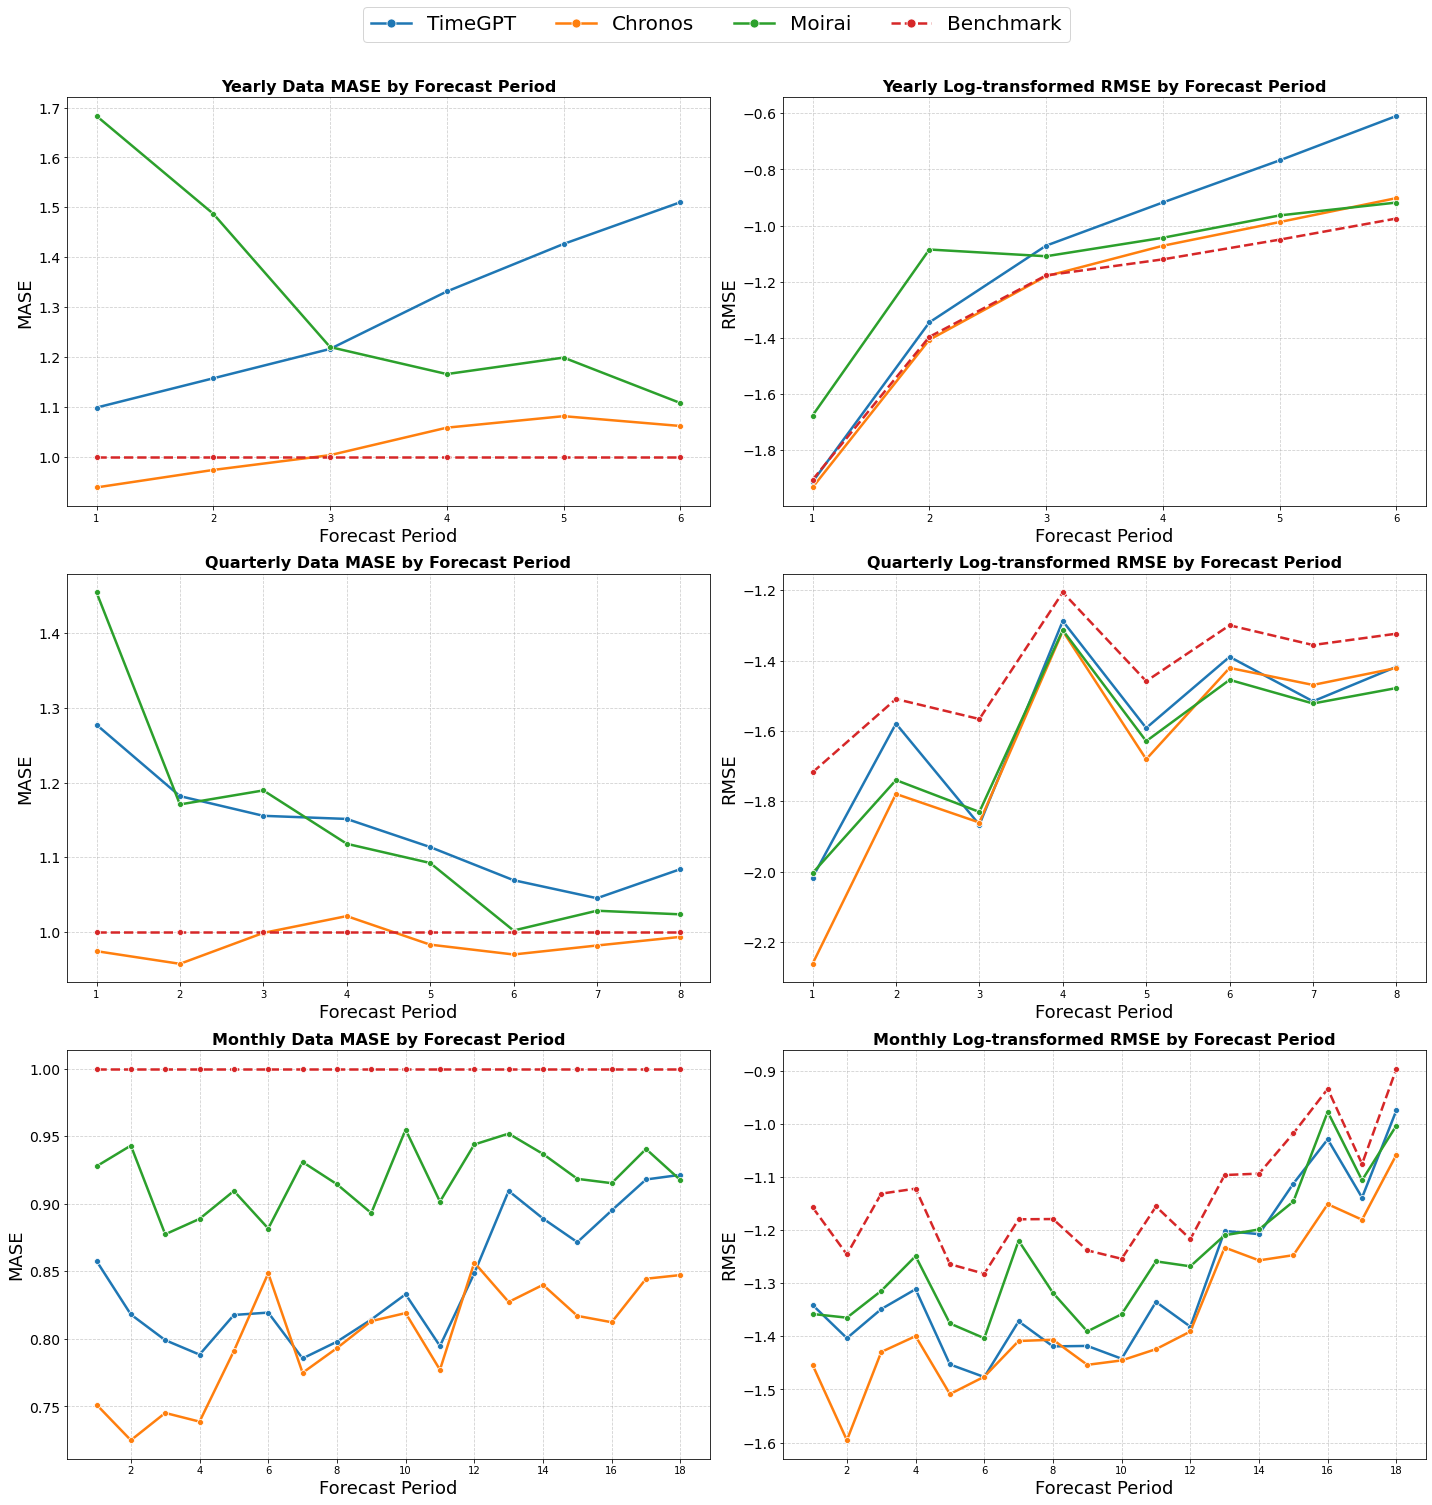

In [33]:
# Create a figure with 1 row and 3 columns of subplots
fig, axes = plt.subplots(3, 2, figsize=(20, 20))

### MASE ###

# Yearly
sns.lineplot(ax=axes[0, 0], x=mase_results_period_year.index, y=mase_results_period_year['TimeGPT'], marker='o', label='TimeGPT', linewidth=2.5)
sns.lineplot(ax=axes[0, 0], x=mase_results_period_year.index, y=mase_results_period_year['Chronos'], marker='o', label='Chronos', linewidth=2.5)
sns.lineplot(ax=axes[0, 0], x=mase_results_period_year.index, y=mase_results_period_year['Moirai'], marker='o', label='Moirai', linewidth=2.5)
sns.lineplot(ax=axes[0, 0], x=mase_results_period_year.index, y=mase_results_period_year['NAIVE2'], marker='o', linestyle='--', label='Benchmark', linewidth=2.5)
# Title and labels
axes[0, 0].set_title('Yearly Data MASE by Forecast Period', fontsize=16, fontweight='bold')
axes[0, 0].set_xlabel('Forecast Period', fontsize=18)
axes[0, 0].set_ylabel('MASE', fontsize=18)
axes[0, 0].grid(True, linestyle='--', alpha=0.6)
axes[0, 0].set_xticks(range(1, 6+1))
axes[0, 0].tick_params(axis='y', labelsize=14)

# Quarterly
sns.lineplot(ax=axes[1, 0], x=mase_results_period_quarter.index, y=mase_results_period_quarter['TimeGPT'], marker='o', label='TimeGPT', linewidth=2.5)
sns.lineplot(ax=axes[1, 0], x=mase_results_period_quarter.index, y=mase_results_period_quarter['Chronos'], marker='o', label='Chronos', linewidth=2.5)
sns.lineplot(ax=axes[1, 0], x=mase_results_period_quarter.index, y=mase_results_period_quarter['Moirai'], marker='o', label='Moirai', linewidth=2.5)
sns.lineplot(ax=axes[1, 0], x=mase_results_period_quarter.index, y=mase_results_period_quarter['NAIVE2'], marker='o', linestyle='--', label='Benchmark', linewidth=2.5)
# Title and labels
axes[1, 0].set_title('Quarterly Data MASE by Forecast Period', fontsize=16, fontweight='bold')
axes[1, 0].set_xlabel('Forecast Period', fontsize=18)
axes[1, 0].set_ylabel('MASE', fontsize=18)
axes[1, 0].grid(True, linestyle='--', alpha=0.6)
axes[1, 0].set_xticks(range(1, 8+1))
axes[1, 0].tick_params(axis='y', labelsize=14)

# Monthly
sns.lineplot(ax=axes[2, 0], x=mase_results_period_month.index, y=mase_results_period_month['TimeGPT'], marker='o', label='TimeGPT', linewidth=2.5)
sns.lineplot(ax=axes[2, 0], x=mase_results_period_month.index, y=mase_results_period_month['Chronos'], marker='o', label='Chronos', linewidth=2.5)
sns.lineplot(ax=axes[2, 0], x=mase_results_period_month.index, y=mase_results_period_month['Moirai'], marker='o', label='Moirai', linewidth=2.5)
sns.lineplot(ax=axes[2, 0], x=mase_results_period_month.index, y=mase_results_period_month['NAIVE2'], marker='o', linestyle='--', label='Benchmark', linewidth=2.5)
# Title and labels
axes[2, 0].set_title('Monthly Data MASE by Forecast Period', fontsize=16, fontweight='bold')
axes[2, 0].set_xlabel('Forecast Period', fontsize=18)
axes[2, 0].set_ylabel('MASE', fontsize=18)
axes[2, 0].grid(True, linestyle='--', alpha=0.6)
axes[2, 0].set_xticks(range(2, 18+1, 2))
axes[2, 0].tick_params(axis='y', labelsize=14)


### RMSE ###

# Yearly
sns.lineplot(ax=axes[0, 1], x=rmse_results_period_year.index, y=np.log(rmse_results_period_year['TimeGPT']), marker='o', label='TimeGPT', linewidth=2.5)
sns.lineplot(ax=axes[0, 1], x=rmse_results_period_year.index, y=np.log(rmse_results_period_year['Chronos']), marker='o', label='Chronos', linewidth=2.5)
sns.lineplot(ax=axes[0, 1], x=rmse_results_period_year.index, y=np.log(rmse_results_period_year['Moirai']), marker='o', label='Moirai', linewidth=2.5)
sns.lineplot(ax=axes[0, 1], x=rmse_results_period_year.index, y=np.log(rmse_results_period_year['NAIVE2']), marker='o', linestyle='--', label='Benchmark', linewidth=2.5)
# Title and labels
axes[0, 1].set_title('Yearly Log-transformed RMSE by Forecast Period', fontsize=16, fontweight='bold')
axes[0, 1].set_xlabel('Forecast Period', fontsize=18)
axes[0, 1].set_ylabel('RMSE', fontsize=18)
axes[0, 1].grid(True, linestyle='--', alpha=0.6)
axes[0, 1].set_xticks(range(1, 6+1))
axes[0, 1].tick_params(axis='y', labelsize=14)

# Quarterly
sns.lineplot(ax=axes[1, 1], x=rmse_results_period_quarter.index, y=np.log(rmse_results_period_quarter['TimeGPT']), marker='o', label='TimeGPT', linewidth=2.5)
sns.lineplot(ax=axes[1, 1], x=rmse_results_period_quarter.index, y=np.log(rmse_results_period_quarter['Chronos']), marker='o', label='Chronos', linewidth=2.5)
sns.lineplot(ax=axes[1, 1], x=rmse_results_period_quarter.index, y=np.log(rmse_results_period_quarter['Moirai']), marker='o', label='Moirai', linewidth=2.5)
sns.lineplot(ax=axes[1, 1], x=rmse_results_period_quarter.index, y=np.log(rmse_results_period_quarter['NAIVE2']), marker='o', linestyle='--', label='Benchmark', linewidth=2.5)
# Title and labels
axes[1, 1].set_title('Quarterly Log-transformed RMSE by Forecast Period', fontsize=16, fontweight='bold')
axes[1, 1].set_xlabel('Forecast Period', fontsize=18)
axes[1, 1].set_ylabel('RMSE', fontsize=18)
axes[1, 1].grid(True, linestyle='--', alpha=0.6)
axes[1, 1].set_xticks(range(1, 8+1))
axes[1, 1].tick_params(axis='y', labelsize=14)

# Monthly
sns.lineplot(ax=axes[2, 1], x=rmse_results_period_month.index, y=np.log(rmse_results_period_month['TimeGPT']), marker='o', label='TimeGPT', linewidth=2.5)
sns.lineplot(ax=axes[2, 1], x=rmse_results_period_month.index, y=np.log(rmse_results_period_month['Chronos']), marker='o', label='Chronos', linewidth=2.5)
sns.lineplot(ax=axes[2, 1], x=rmse_results_period_month.index, y=np.log(rmse_results_period_month['Moirai']), marker='o', label='Moirai', linewidth=2.5)
sns.lineplot(ax=axes[2, 1], x=rmse_results_period_month.index, y=np.log(rmse_results_period_month['NAIVE2']), marker='o', linestyle='--', label='Benchmark', linewidth=2.5)
# Title and labels
axes[2, 1].set_title('Monthly Log-transformed RMSE by Forecast Period', fontsize=16, fontweight='bold')
axes[2, 1].set_xlabel('Forecast Period', fontsize=18)
axes[2, 1].set_ylabel('RMSE', fontsize=18)
axes[2, 1].grid(True, linestyle='--', alpha=0.6)
axes[2, 1].set_xticks(range(2, 18+1, 2))
axes[2, 1].tick_params(axis='y', labelsize=14)

# Remove legends from the individual plots in favor of a single legend above
for ax in axes.flat:
    ax.legend().remove()

# Common legend
fig.subplots_adjust(top=0.85)

# Legend placement at the top and span the full figure width
handles, labels = axes[0, 0].get_legend_handles_labels()  # You can also gather labels from all subplots if they vary
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1.05), ncol=len(labels), fontsize=20, markerscale=1.5, handlelength=2)

# Adjust layout to prevent overlapping
plt.tight_layout()

plt.show()


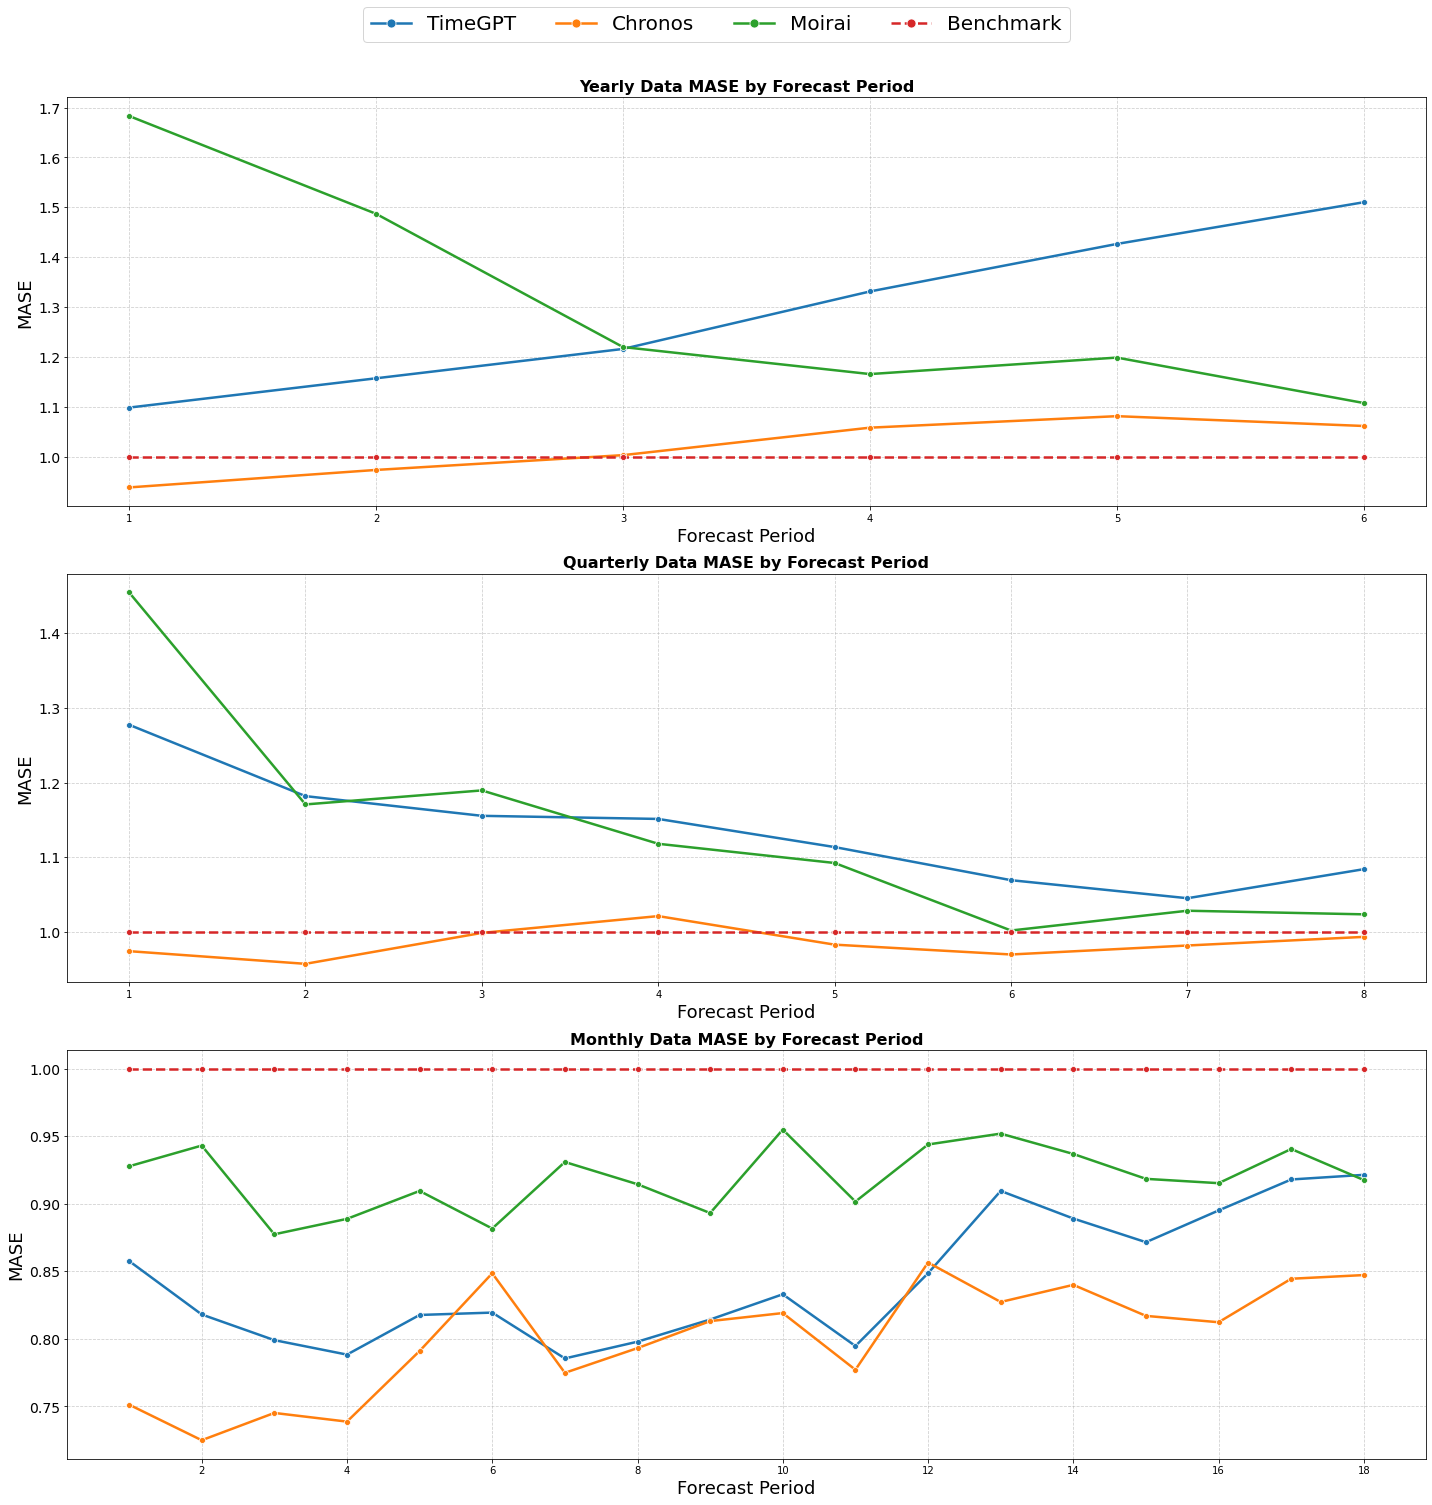

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a figure with 1 row and 3 columns of subplots
fig, axes = plt.subplots(3, 1, figsize=(20, 20))

### MASE ###

# Yearly
sns.lineplot(ax=axes[0], x=mase_results_period_year.index, y=mase_results_period_year['TimeGPT'], marker='o', label='TimeGPT', linewidth=2.5)
sns.lineplot(ax=axes[0], x=mase_results_period_year.index, y=mase_results_period_year['Chronos'], marker='o', label='Chronos', linewidth=2.5)
sns.lineplot(ax=axes[0], x=mase_results_period_year.index, y=mase_results_period_year['Moirai'], marker='o', label='Moirai', linewidth=2.5)
sns.lineplot(ax=axes[0], x=mase_results_period_year.index, y=mase_results_period_year['NAIVE2'], marker='o', linestyle='--', label='Benchmark', linewidth=2.5)
# Title and labels
axes[0].set_title('Yearly Data MASE by Forecast Period', fontsize=16, fontweight='bold')
axes[0].set_xlabel('Forecast Period', fontsize=18)
axes[0].set_ylabel('MASE', fontsize=18)
axes[0].grid(True, linestyle='--', alpha=0.6)
axes[0].set_xticks(range(1, 6+1))
axes[0].tick_params(axis='y', labelsize=14)

# Quarterly
sns.lineplot(ax=axes[1], x=mase_results_period_quarter.index, y=mase_results_period_quarter['TimeGPT'], marker='o', label='TimeGPT', linewidth=2.5)
sns.lineplot(ax=axes[1], x=mase_results_period_quarter.index, y=mase_results_period_quarter['Chronos'], marker='o', label='Chronos', linewidth=2.5)
sns.lineplot(ax=axes[1], x=mase_results_period_quarter.index, y=mase_results_period_quarter['Moirai'], marker='o', label='Moirai', linewidth=2.5)
sns.lineplot(ax=axes[1], x=mase_results_period_quarter.index, y=mase_results_period_quarter['NAIVE2'], marker='o', linestyle='--', label='Benchmark', linewidth=2.5)
# Title and labels
axes[1].set_title('Quarterly Data MASE by Forecast Period', fontsize=16, fontweight='bold')
axes[1].set_xlabel('Forecast Period', fontsize=18)
axes[1].set_ylabel('MASE', fontsize=18)
axes[1].grid(True, linestyle='--', alpha=0.6)
axes[1].set_xticks(range(1, 8+1))
axes[1].tick_params(axis='y', labelsize=14)

# Monthly
sns.lineplot(ax=axes[2], x=mase_results_period_month.index, y=mase_results_period_month['TimeGPT'], marker='o', label='TimeGPT', linewidth=2.5)
sns.lineplot(ax=axes[2], x=mase_results_period_month.index, y=mase_results_period_month['Chronos'], marker='o', label='Chronos', linewidth=2.5)
sns.lineplot(ax=axes[2], x=mase_results_period_month.index, y=mase_results_period_month['Moirai'], marker='o', label='Moirai', linewidth=2.5)
sns.lineplot(ax=axes[2], x=mase_results_period_month.index, y=mase_results_period_month['NAIVE2'], marker='o', linestyle='--', label='Benchmark', linewidth=2.5)
# Title and labels
axes[2].set_title('Monthly Data MASE by Forecast Period', fontsize=16, fontweight='bold')
axes[2].set_xlabel('Forecast Period', fontsize=18)
axes[2].set_ylabel('MASE', fontsize=18)
axes[2].grid(True, linestyle='--', alpha=0.6)
axes[2].set_xticks(range(2, 18+1, 2))
axes[2].tick_params(axis='y', labelsize=14)

# Remove legends from the individual plots in favor of a single legend above
for ax in axes.flat:
    ax.legend().remove()

# Common legend
fig.subplots_adjust(top=0.85)

# Legend placement at the top and span the full figure width
handles, labels = axes[0].get_legend_handles_labels()  # You can also gather labels from all subplots if they vary
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1.05), ncol=len(labels), fontsize=20, markerscale=1.5, handlelength=2)

# Adjust layout to prevent overlapping
plt.tight_layout()

plt.show()


## Forecast Period MASE and RMSE Distribution

### Calculate MASE for each forecast period in each series

In [33]:
complete_df = results_df.copy()
# complete_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35622 entries, 0 to 35621
Data columns (total 31 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Series          35622 non-null  int64         
 1   Date            35622 non-null  datetime64[us]
 2   TimeGPT         35622 non-null  float64       
 3   Chronos         35622 non-null  float64       
 4   Moirai          35622 non-null  float32       
 5   ForecastPeriod  35622 non-null  int64         
 6   ARARMA          35622 non-null  float64       
 7   Auto-ANN        35622 non-null  float64       
 8   AutoBox1        35622 non-null  float64       
 9   AutoBox2        35622 non-null  float64       
 10  AutoBox3        35622 non-null  float64       
 11  B-J auto        35622 non-null  float64       
 12  COMB S-H-D      35622 non-null  float64       
 13  DAMPEN          35622 non-null  float64       
 14  Flors-Pearc1    35622 non-null  float64       
 15  Fl

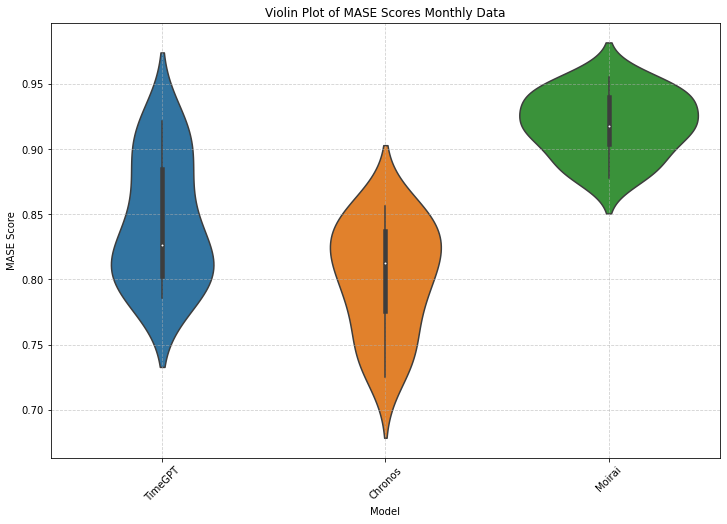

In [35]:
plt.figure(figsize=(12, 8))
sns.violinplot(data=mase_results_period_month[['TimeGPT', 'Chronos', 'Moirai']])
plt.title('Violin Plot of MASE Scores Monthly Data')
plt.xlabel('Model')
plt.ylabel('MASE Score')
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

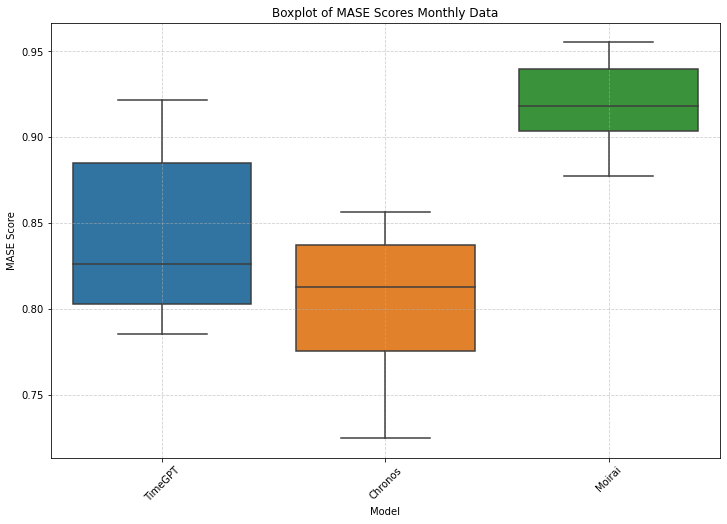

In [58]:
plt.figure(figsize=(12, 8))
sns.boxplot(data=mase_results_period_month[['TimeGPT', 'Chronos', 'Moirai']])
plt.title('Boxplot of MASE Scores Monthly Data')
plt.xlabel('Model')
plt.ylabel('MASE Score')
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

Go for boxplot for now

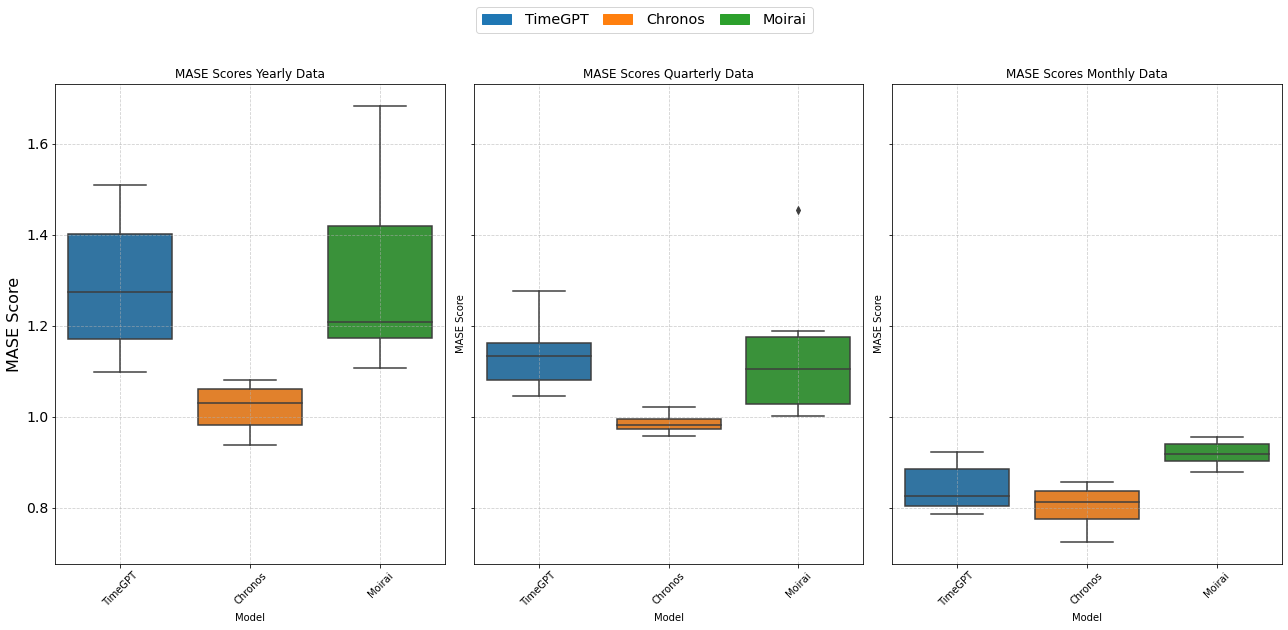

In [87]:
# Define models to be displayed in each boxplot
models = ['TimeGPT', 'Chronos', 'Moirai']

# Define the palette with specific colors for each model
custom_palette = {
    'TimeGPT': '#1f77b4',  # Blue
    'Chronos': '#ff7f0e',  # Orange
    'Moirai': '#2ca02c'    # Green
}

# List of data frames and their corresponding titles
mase_results = [
    (mase_results_period_year, 'MASE Scores Yearly Data'),
    (mase_results_period_quarter, 'MASE Scores Quarterly Data'),
    (mase_results_period_month, 'MASE Scores Monthly Data')
]

# Create subplots
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(18, 8), sharey=True)

# Loop through each data frame and its respective axis to plot each boxplot
for ax, (df, title) in zip(axs, mase_results):
    sns.boxplot(data=df[models], ax=ax, palette=[custom_palette[model] for model in models])
    ax.set_title(title)
    ax.set_xlabel('Model')
    ax.set_ylabel('MASE Score')
    ax.grid(True, linestyle='--', alpha=0.6)
    ax.tick_params(axis='x', rotation=45)

axs[0].tick_params(axis='y', labelsize=14)  # Change the `labelsize` as needed
axs[0].set_ylabel('MASE Score', fontsize=16)  # Adjust the `fontsize` as needed

# Add a legend manually using matplotlib patches
legend_labels = [Patch(color=custom_palette[model], label=model) for model in models]
fig.legend(
    handles=legend_labels,
    loc='upper center',
    ncol=len(models),
    fontsize='x-large',
    bbox_to_anchor=(0.5, 1.1),  # Position legend above the plots
    frameon=True,
    columnspacing=1,           # Increase spacing between columns
    handletextpad=1            # Padding between handles and text
)
# Adjust the layout for better spacing
fig.tight_layout()

# Show the combined plots
plt.show()
